In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


Loaded 81589 images
Dataset type test label type: species


Loaded 78017 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 yvidpe3r


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                               | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                      | 1/685 [00:00<10:26,  1.09it/s]

  0%|▍                                                                                                                                                      | 2/685 [00:01<05:26,  2.09it/s]

  0%|▋                                                                                                                                                      | 3/685 [00:01<03:50,  2.96it/s]

  1%|▉                                                                                                                                                      | 4/685 [00:01<03:04,  3.68it/s]

  1%|█                                                                                                                                                      | 5/685 [00:01<02:40,  4.25it/s]

  1%|█▎                                                                                                                                                     | 6/685 [00:01<02:24,  4.68it/s]

  1%|█▌                                                                                                                                                     | 7/685 [00:01<02:15,  5.01it/s]

  1%|█▊                                                                                                                                                     | 8/685 [00:02<02:08,  5.25it/s]

  1%|█▉                                                                                                                                                     | 9/685 [00:02<02:04,  5.43it/s]

  1%|██▏                                                                                                                                                   | 10/685 [00:02<02:01,  5.55it/s]

  2%|██▍                                                                                                                                                   | 11/685 [00:02<01:59,  5.64it/s]

  2%|██▋                                                                                                                                                   | 12/685 [00:02<01:57,  5.70it/s]

  2%|██▊                                                                                                                                                   | 13/685 [00:02<01:56,  5.75it/s]

  2%|███                                                                                                                                                   | 14/685 [00:03<01:56,  5.78it/s]

  2%|███▎                                                                                                                                                  | 15/685 [00:03<01:55,  5.80it/s]

  2%|███▌                                                                                                                                                  | 16/685 [00:03<01:55,  5.81it/s]

  2%|███▋                                                                                                                                                  | 17/685 [00:03<01:54,  5.82it/s]

  3%|███▉                                                                                                                                                  | 18/685 [00:03<01:54,  5.82it/s]

  3%|████▏                                                                                                                                                 | 19/685 [00:03<01:54,  5.83it/s]

  3%|████▍                                                                                                                                                 | 20/685 [00:04<01:53,  5.84it/s]

  3%|████▌                                                                                                                                                 | 21/685 [00:04<01:53,  5.84it/s]

  3%|████▊                                                                                                                                                 | 22/685 [00:04<01:53,  5.85it/s]

  3%|█████                                                                                                                                                 | 23/685 [00:04<01:53,  5.84it/s]

  4%|█████▎                                                                                                                                                | 24/685 [00:04<01:53,  5.85it/s]

  4%|█████▍                                                                                                                                                | 25/685 [00:05<01:52,  5.85it/s]

  4%|█████▋                                                                                                                                                | 26/685 [00:05<01:52,  5.85it/s]

  4%|█████▉                                                                                                                                                | 27/685 [00:05<01:52,  5.85it/s]

  4%|██████▏                                                                                                                                               | 28/685 [00:05<01:52,  5.85it/s]

  4%|██████▎                                                                                                                                               | 29/685 [00:05<01:52,  5.85it/s]

  4%|██████▌                                                                                                                                               | 30/685 [00:05<01:52,  5.84it/s]

  5%|██████▊                                                                                                                                               | 31/685 [00:06<01:51,  5.85it/s]

  5%|███████                                                                                                                                               | 32/685 [00:06<01:51,  5.85it/s]

  5%|███████▏                                                                                                                                              | 33/685 [00:06<01:51,  5.85it/s]

  5%|███████▍                                                                                                                                              | 34/685 [00:06<01:51,  5.85it/s]

  5%|███████▋                                                                                                                                              | 35/685 [00:06<01:51,  5.85it/s]

  5%|███████▉                                                                                                                                              | 36/685 [00:06<01:50,  5.85it/s]

  5%|████████                                                                                                                                              | 37/685 [00:07<01:50,  5.84it/s]

  6%|████████▎                                                                                                                                             | 38/685 [00:07<01:50,  5.85it/s]

  6%|████████▌                                                                                                                                             | 39/685 [00:07<01:50,  5.85it/s]

  6%|████████▊                                                                                                                                             | 40/685 [00:07<01:50,  5.85it/s]

  6%|████████▉                                                                                                                                             | 41/685 [00:07<01:50,  5.85it/s]

  6%|█████████▏                                                                                                                                            | 42/685 [00:07<01:49,  5.85it/s]

  6%|█████████▍                                                                                                                                            | 43/685 [00:08<01:49,  5.85it/s]

  6%|█████████▋                                                                                                                                            | 44/685 [00:08<01:49,  5.85it/s]

  7%|█████████▊                                                                                                                                            | 45/685 [00:08<01:49,  5.85it/s]

  7%|██████████                                                                                                                                            | 46/685 [00:08<01:49,  5.85it/s]

  7%|██████████▎                                                                                                                                           | 47/685 [00:08<01:49,  5.85it/s]

  7%|██████████▌                                                                                                                                           | 48/685 [00:08<01:48,  5.85it/s]

  7%|██████████▋                                                                                                                                           | 49/685 [00:09<01:48,  5.85it/s]

  7%|██████████▉                                                                                                                                           | 50/685 [00:09<01:48,  5.85it/s]

  7%|███████████▏                                                                                                                                          | 51/685 [00:09<01:48,  5.84it/s]

  8%|███████████▍                                                                                                                                          | 52/685 [00:09<01:48,  5.84it/s]

  8%|███████████▌                                                                                                                                          | 53/685 [00:09<01:48,  5.84it/s]

  8%|███████████▊                                                                                                                                          | 54/685 [00:09<01:48,  5.83it/s]

  8%|████████████                                                                                                                                          | 55/685 [00:10<01:48,  5.83it/s]

  8%|████████████▎                                                                                                                                         | 56/685 [00:10<01:47,  5.83it/s]

  8%|████████████▍                                                                                                                                         | 57/685 [00:10<01:47,  5.83it/s]

  8%|████████████▋                                                                                                                                         | 58/685 [00:10<01:47,  5.82it/s]

  9%|████████████▉                                                                                                                                         | 59/685 [00:10<01:47,  5.83it/s]

  9%|█████████████▏                                                                                                                                        | 60/685 [00:11<01:47,  5.83it/s]

  9%|█████████████▎                                                                                                                                        | 61/685 [00:11<01:46,  5.84it/s]

  9%|█████████████▌                                                                                                                                        | 62/685 [00:11<01:46,  5.84it/s]

  9%|█████████████▊                                                                                                                                        | 63/685 [00:11<01:46,  5.84it/s]

  9%|██████████████                                                                                                                                        | 64/685 [00:11<01:46,  5.85it/s]

  9%|██████████████▏                                                                                                                                       | 65/685 [00:11<01:46,  5.84it/s]

 10%|██████████████▍                                                                                                                                       | 66/685 [00:12<01:45,  5.84it/s]

 10%|██████████████▋                                                                                                                                       | 67/685 [00:12<01:45,  5.84it/s]

 10%|██████████████▉                                                                                                                                       | 68/685 [00:12<01:45,  5.84it/s]

 10%|███████████████                                                                                                                                       | 69/685 [00:12<01:45,  5.85it/s]

 10%|███████████████▎                                                                                                                                      | 70/685 [00:12<01:45,  5.85it/s]

 10%|███████████████▌                                                                                                                                      | 71/685 [00:12<01:44,  5.85it/s]

 11%|███████████████▊                                                                                                                                      | 72/685 [00:13<01:44,  5.84it/s]

 11%|███████████████▉                                                                                                                                      | 73/685 [00:13<01:44,  5.85it/s]

 11%|████████████████▏                                                                                                                                     | 74/685 [00:13<01:44,  5.85it/s]

 11%|████████████████▍                                                                                                                                     | 75/685 [00:13<01:44,  5.85it/s]

 11%|████████████████▋                                                                                                                                     | 76/685 [00:13<01:44,  5.85it/s]

 11%|████████████████▊                                                                                                                                     | 77/685 [00:13<01:43,  5.85it/s]

 11%|█████████████████                                                                                                                                     | 78/685 [00:14<01:43,  5.85it/s]

 12%|█████████████████▎                                                                                                                                    | 79/685 [00:14<01:43,  5.84it/s]

 12%|█████████████████▌                                                                                                                                    | 80/685 [00:14<01:43,  5.83it/s]

 12%|█████████████████▋                                                                                                                                    | 81/685 [00:14<01:43,  5.83it/s]

 12%|█████████████████▉                                                                                                                                    | 82/685 [00:14<01:43,  5.84it/s]

 12%|██████████████████▏                                                                                                                                   | 83/685 [00:14<01:43,  5.84it/s]

 12%|██████████████████▍                                                                                                                                   | 84/685 [00:15<01:42,  5.84it/s]

 12%|██████████████████▌                                                                                                                                   | 85/685 [00:15<01:42,  5.85it/s]

 13%|██████████████████▊                                                                                                                                   | 86/685 [00:15<01:42,  5.85it/s]

 13%|███████████████████                                                                                                                                   | 87/685 [00:15<01:42,  5.85it/s]

 13%|███████████████████▎                                                                                                                                  | 88/685 [00:15<01:42,  5.85it/s]

 13%|███████████████████▍                                                                                                                                  | 89/685 [00:15<01:41,  5.85it/s]

 13%|███████████████████▋                                                                                                                                  | 90/685 [00:16<01:41,  5.85it/s]

 13%|███████████████████▉                                                                                                                                  | 91/685 [00:16<01:41,  5.86it/s]

 13%|████████████████████▏                                                                                                                                 | 92/685 [00:16<01:41,  5.86it/s]

 14%|████████████████████▎                                                                                                                                 | 93/685 [00:16<01:41,  5.85it/s]

 14%|████████████████████▌                                                                                                                                 | 94/685 [00:16<01:40,  5.85it/s]

 14%|████████████████████▊                                                                                                                                 | 95/685 [00:16<01:40,  5.85it/s]

 14%|█████████████████████                                                                                                                                 | 96/685 [00:17<01:40,  5.86it/s]

 14%|█████████████████████▏                                                                                                                                | 97/685 [00:17<01:40,  5.86it/s]

 14%|█████████████████████▍                                                                                                                                | 98/685 [00:17<01:40,  5.86it/s]

 14%|█████████████████████▋                                                                                                                                | 99/685 [00:17<01:39,  5.86it/s]

 15%|█████████████████████▊                                                                                                                               | 100/685 [00:17<01:39,  5.85it/s]

 15%|█████████████████████▉                                                                                                                               | 101/685 [00:18<01:39,  5.85it/s]

 15%|██████████████████████▏                                                                                                                              | 102/685 [00:18<01:39,  5.85it/s]

 15%|██████████████████████▍                                                                                                                              | 103/685 [00:18<01:39,  5.85it/s]

 15%|██████████████████████▌                                                                                                                              | 104/685 [00:18<01:39,  5.84it/s]

 15%|██████████████████████▊                                                                                                                              | 105/685 [00:18<01:39,  5.84it/s]

 15%|███████████████████████                                                                                                                              | 106/685 [00:18<01:39,  5.84it/s]

 16%|███████████████████████▎                                                                                                                             | 107/685 [00:19<01:39,  5.83it/s]

 16%|███████████████████████▍                                                                                                                             | 108/685 [00:19<01:39,  5.83it/s]

 16%|███████████████████████▋                                                                                                                             | 109/685 [00:19<01:38,  5.83it/s]

 16%|███████████████████████▉                                                                                                                             | 110/685 [00:19<01:38,  5.83it/s]

 16%|████████████████████████▏                                                                                                                            | 111/685 [00:19<01:38,  5.83it/s]

 16%|████████████████████████▎                                                                                                                            | 112/685 [00:19<01:38,  5.83it/s]

 16%|████████████████████████▌                                                                                                                            | 113/685 [00:20<01:38,  5.83it/s]

 17%|████████████████████████▊                                                                                                                            | 114/685 [00:20<01:38,  5.82it/s]

 17%|█████████████████████████                                                                                                                            | 115/685 [00:20<01:37,  5.83it/s]

 17%|█████████████████████████▏                                                                                                                           | 116/685 [00:20<01:37,  5.84it/s]

 17%|█████████████████████████▍                                                                                                                           | 117/685 [00:20<01:37,  5.85it/s]

 17%|█████████████████████████▋                                                                                                                           | 118/685 [00:20<01:36,  5.85it/s]

 17%|█████████████████████████▉                                                                                                                           | 119/685 [00:21<01:36,  5.86it/s]

 18%|██████████████████████████                                                                                                                           | 120/685 [00:21<01:36,  5.86it/s]

 18%|██████████████████████████▎                                                                                                                          | 121/685 [00:21<01:36,  5.85it/s]

 18%|██████████████████████████▌                                                                                                                          | 122/685 [00:21<01:36,  5.85it/s]

 18%|██████████████████████████▊                                                                                                                          | 123/685 [00:21<01:35,  5.86it/s]

 18%|██████████████████████████▉                                                                                                                          | 124/685 [00:21<01:35,  5.86it/s]

 18%|███████████████████████████▏                                                                                                                         | 125/685 [00:22<01:35,  5.85it/s]

 18%|███████████████████████████▍                                                                                                                         | 126/685 [00:22<01:35,  5.85it/s]

 19%|███████████████████████████▌                                                                                                                         | 127/685 [00:22<01:35,  5.83it/s]

 19%|███████████████████████████▊                                                                                                                         | 128/685 [00:22<01:35,  5.83it/s]

 19%|████████████████████████████                                                                                                                         | 129/685 [00:22<01:35,  5.83it/s]

 19%|████████████████████████████▎                                                                                                                        | 130/685 [00:22<01:35,  5.83it/s]

 19%|████████████████████████████▍                                                                                                                        | 131/685 [00:23<01:34,  5.83it/s]

 19%|████████████████████████████▋                                                                                                                        | 132/685 [00:23<01:34,  5.83it/s]

 19%|████████████████████████████▉                                                                                                                        | 133/685 [00:23<01:34,  5.83it/s]

 20%|█████████████████████████████▏                                                                                                                       | 134/685 [00:23<01:34,  5.83it/s]

 20%|█████████████████████████████▎                                                                                                                       | 135/685 [00:23<01:34,  5.83it/s]

 20%|█████████████████████████████▌                                                                                                                       | 136/685 [00:24<01:34,  5.83it/s]

 20%|█████████████████████████████▊                                                                                                                       | 137/685 [00:24<01:34,  5.82it/s]

 20%|██████████████████████████████                                                                                                                       | 138/685 [00:24<01:33,  5.82it/s]

 20%|██████████████████████████████▏                                                                                                                      | 139/685 [00:24<01:33,  5.82it/s]

 20%|██████████████████████████████▍                                                                                                                      | 140/685 [00:24<01:33,  5.83it/s]

 21%|██████████████████████████████▋                                                                                                                      | 141/685 [00:24<01:33,  5.84it/s]

 21%|██████████████████████████████▉                                                                                                                      | 142/685 [00:25<01:33,  5.84it/s]

 21%|███████████████████████████████                                                                                                                      | 143/685 [00:25<01:32,  5.84it/s]

 21%|███████████████████████████████▎                                                                                                                     | 144/685 [00:25<01:32,  5.85it/s]

 21%|███████████████████████████████▌                                                                                                                     | 145/685 [00:25<01:32,  5.85it/s]

 21%|███████████████████████████████▊                                                                                                                     | 146/685 [00:25<01:32,  5.85it/s]

 21%|███████████████████████████████▉                                                                                                                     | 147/685 [00:25<01:31,  5.86it/s]

 22%|████████████████████████████████▏                                                                                                                    | 148/685 [00:26<01:31,  5.86it/s]

 22%|████████████████████████████████▍                                                                                                                    | 149/685 [00:26<01:31,  5.85it/s]

 22%|████████████████████████████████▋                                                                                                                    | 150/685 [00:26<01:31,  5.85it/s]

 22%|████████████████████████████████▊                                                                                                                    | 151/685 [00:26<01:31,  5.85it/s]

 22%|█████████████████████████████████                                                                                                                    | 152/685 [00:26<01:31,  5.85it/s]

 22%|█████████████████████████████████▎                                                                                                                   | 153/685 [00:26<01:30,  5.85it/s]

 22%|█████████████████████████████████▍                                                                                                                   | 154/685 [00:27<01:30,  5.84it/s]

 23%|█████████████████████████████████▋                                                                                                                   | 155/685 [00:27<01:30,  5.84it/s]

 23%|█████████████████████████████████▉                                                                                                                   | 156/685 [00:27<01:30,  5.84it/s]

 23%|██████████████████████████████████▏                                                                                                                  | 157/685 [00:27<01:30,  5.84it/s]

 23%|██████████████████████████████████▎                                                                                                                  | 158/685 [00:27<01:30,  5.84it/s]

 23%|██████████████████████████████████▌                                                                                                                  | 159/685 [00:27<01:30,  5.84it/s]

 23%|██████████████████████████████████▊                                                                                                                  | 160/685 [00:28<01:29,  5.84it/s]

 24%|███████████████████████████████████                                                                                                                  | 161/685 [00:28<01:29,  5.84it/s]

 24%|███████████████████████████████████▏                                                                                                                 | 162/685 [00:28<01:29,  5.84it/s]

 24%|███████████████████████████████████▍                                                                                                                 | 163/685 [00:28<01:29,  5.83it/s]

 24%|███████████████████████████████████▋                                                                                                                 | 164/685 [00:28<01:29,  5.83it/s]

 24%|███████████████████████████████████▉                                                                                                                 | 165/685 [00:28<01:29,  5.83it/s]

 24%|████████████████████████████████████                                                                                                                 | 166/685 [00:29<01:28,  5.84it/s]

 24%|████████████████████████████████████▎                                                                                                                | 167/685 [00:29<01:28,  5.84it/s]

 25%|████████████████████████████████████▌                                                                                                                | 168/685 [00:29<01:28,  5.85it/s]

 25%|████████████████████████████████████▊                                                                                                                | 169/685 [00:29<01:28,  5.84it/s]

 25%|████████████████████████████████████▉                                                                                                                | 170/685 [00:29<01:28,  5.84it/s]

 25%|█████████████████████████████████████▏                                                                                                               | 171/685 [00:30<01:28,  5.84it/s]

 25%|█████████████████████████████████████▍                                                                                                               | 172/685 [00:30<01:27,  5.84it/s]

 25%|█████████████████████████████████████▋                                                                                                               | 173/685 [00:30<01:27,  5.85it/s]

 25%|█████████████████████████████████████▊                                                                                                               | 174/685 [00:30<01:27,  5.85it/s]

 26%|██████████████████████████████████████                                                                                                               | 175/685 [00:30<01:27,  5.86it/s]

 26%|██████████████████████████████████████▎                                                                                                              | 176/685 [00:30<01:26,  5.86it/s]

 26%|██████████████████████████████████████▌                                                                                                              | 177/685 [00:31<01:26,  5.85it/s]

 26%|██████████████████████████████████████▋                                                                                                              | 178/685 [00:31<01:26,  5.86it/s]

 26%|██████████████████████████████████████▉                                                                                                              | 179/685 [00:31<01:26,  5.86it/s]

 26%|███████████████████████████████████████▏                                                                                                             | 180/685 [00:31<01:26,  5.86it/s]

 26%|███████████████████████████████████████▎                                                                                                             | 181/685 [00:31<01:26,  5.86it/s]

 27%|███████████████████████████████████████▌                                                                                                             | 182/685 [00:31<01:25,  5.86it/s]

 27%|███████████████████████████████████████▊                                                                                                             | 183/685 [00:32<01:25,  5.86it/s]

 27%|████████████████████████████████████████                                                                                                             | 184/685 [00:32<01:25,  5.85it/s]

 27%|████████████████████████████████████████▏                                                                                                            | 185/685 [00:32<01:25,  5.86it/s]

 27%|████████████████████████████████████████▍                                                                                                            | 186/685 [00:32<01:25,  5.86it/s]

 27%|████████████████████████████████████████▋                                                                                                            | 187/685 [00:32<01:24,  5.86it/s]

 27%|████████████████████████████████████████▉                                                                                                            | 188/685 [00:32<01:24,  5.86it/s]

 28%|█████████████████████████████████████████                                                                                                            | 189/685 [00:33<01:24,  5.86it/s]

 28%|█████████████████████████████████████████▎                                                                                                           | 190/685 [00:33<01:24,  5.86it/s]

 28%|█████████████████████████████████████████▌                                                                                                           | 191/685 [00:33<01:24,  5.85it/s]

 28%|█████████████████████████████████████████▊                                                                                                           | 192/685 [00:33<01:24,  5.85it/s]

 28%|█████████████████████████████████████████▉                                                                                                           | 193/685 [00:33<01:23,  5.86it/s]

 28%|██████████████████████████████████████████▏                                                                                                          | 194/685 [00:33<01:23,  5.86it/s]

 28%|██████████████████████████████████████████▍                                                                                                          | 195/685 [00:34<01:23,  5.86it/s]

 29%|██████████████████████████████████████████▋                                                                                                          | 196/685 [00:34<01:23,  5.86it/s]

 29%|██████████████████████████████████████████▊                                                                                                          | 197/685 [00:34<01:23,  5.86it/s]

 29%|███████████████████████████████████████████                                                                                                          | 198/685 [00:34<01:23,  5.86it/s]

 29%|███████████████████████████████████████████▎                                                                                                         | 199/685 [00:34<01:22,  5.86it/s]

 29%|███████████████████████████████████████████▌                                                                                                         | 200/685 [00:34<01:22,  5.86it/s]

 29%|███████████████████████████████████████████▋                                                                                                         | 201/685 [00:35<01:22,  5.85it/s]

 29%|███████████████████████████████████████████▉                                                                                                         | 202/685 [00:35<01:22,  5.85it/s]

 30%|████████████████████████████████████████████▏                                                                                                        | 203/685 [00:35<01:22,  5.85it/s]

 30%|████████████████████████████████████████████▎                                                                                                        | 204/685 [00:35<01:22,  5.85it/s]

 30%|████████████████████████████████████████████▌                                                                                                        | 205/685 [00:35<01:22,  5.85it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 206/685 [00:35<01:21,  5.85it/s]

 30%|█████████████████████████████████████████████                                                                                                        | 207/685 [00:36<01:21,  5.86it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 208/685 [00:36<01:21,  5.86it/s]

 31%|█████████████████████████████████████████████▍                                                                                                       | 209/685 [00:36<01:21,  5.85it/s]

 31%|█████████████████████████████████████████████▋                                                                                                       | 210/685 [00:36<01:21,  5.85it/s]

 31%|█████████████████████████████████████████████▉                                                                                                       | 211/685 [00:36<01:20,  5.85it/s]

 31%|██████████████████████████████████████████████                                                                                                       | 212/685 [00:37<01:20,  5.85it/s]

 31%|██████████████████████████████████████████████▎                                                                                                      | 213/685 [00:37<01:20,  5.85it/s]

 31%|██████████████████████████████████████████████▌                                                                                                      | 214/685 [00:37<01:20,  5.85it/s]

 31%|██████████████████████████████████████████████▊                                                                                                      | 215/685 [00:37<01:20,  5.85it/s]

 32%|██████████████████████████████████████████████▉                                                                                                      | 216/685 [00:37<01:20,  5.86it/s]

 32%|███████████████████████████████████████████████▏                                                                                                     | 217/685 [00:37<01:19,  5.86it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 218/685 [00:38<01:19,  5.86it/s]

 32%|███████████████████████████████████████████████▋                                                                                                     | 219/685 [00:38<01:19,  5.85it/s]

 32%|███████████████████████████████████████████████▊                                                                                                     | 220/685 [00:38<01:19,  5.86it/s]

 32%|████████████████████████████████████████████████                                                                                                     | 221/685 [00:38<01:19,  5.86it/s]

 32%|████████████████████████████████████████████████▎                                                                                                    | 222/685 [00:38<01:19,  5.85it/s]

 33%|████████████████████████████████████████████████▌                                                                                                    | 223/685 [00:38<01:18,  5.86it/s]

 33%|████████████████████████████████████████████████▋                                                                                                    | 224/685 [00:39<01:18,  5.86it/s]

 33%|████████████████████████████████████████████████▉                                                                                                    | 225/685 [00:39<01:18,  5.86it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                   | 226/685 [00:39<01:18,  5.85it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                   | 227/685 [00:39<01:18,  5.86it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                   | 228/685 [00:39<01:18,  5.86it/s]

 33%|█████████████████████████████████████████████████▊                                                                                                   | 229/685 [00:39<01:17,  5.86it/s]

 34%|██████████████████████████████████████████████████                                                                                                   | 230/685 [00:40<01:17,  5.86it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                  | 231/685 [00:40<01:17,  5.85it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                  | 232/685 [00:40<01:17,  5.86it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                  | 233/685 [00:40<01:17,  5.85it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 234/685 [00:40<01:17,  5.85it/s]

 34%|███████████████████████████████████████████████████                                                                                                  | 235/685 [00:40<01:16,  5.86it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 236/685 [00:41<01:16,  5.86it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 237/685 [00:41<01:16,  5.86it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 238/685 [00:41<01:16,  5.86it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 239/685 [00:41<01:16,  5.86it/s]

 35%|████████████████████████████████████████████████████▏                                                                                                | 240/685 [00:41<01:16,  5.85it/s]

 35%|████████████████████████████████████████████████████▍                                                                                                | 241/685 [00:41<01:15,  5.85it/s]

 35%|████████████████████████████████████████████████████▋                                                                                                | 242/685 [00:42<01:15,  5.86it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 243/685 [00:42<01:15,  5.86it/s]

 36%|█████████████████████████████████████████████████████                                                                                                | 244/685 [00:42<01:15,  5.86it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                               | 245/685 [00:42<01:15,  5.86it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                               | 246/685 [00:42<01:14,  5.86it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 247/685 [00:42<01:14,  5.86it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                               | 248/685 [00:43<01:14,  5.86it/s]

 36%|██████████████████████████████████████████████████████▏                                                                                              | 249/685 [00:43<01:14,  5.86it/s]

 36%|██████████████████████████████████████████████████████▍                                                                                              | 250/685 [00:43<01:14,  5.85it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                              | 251/685 [00:43<01:14,  5.85it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                              | 252/685 [00:43<01:13,  5.85it/s]

 37%|███████████████████████████████████████████████████████                                                                                              | 253/685 [00:44<01:13,  5.86it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                             | 254/685 [00:44<01:13,  5.86it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                             | 255/685 [00:44<01:13,  5.87it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                             | 256/685 [00:44<01:13,  5.87it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                             | 257/685 [00:44<01:13,  5.84it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 258/685 [00:44<01:13,  5.85it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                            | 259/685 [00:45<01:12,  5.86it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                            | 260/685 [00:45<01:12,  5.86it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 261/685 [00:45<01:12,  5.86it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 262/685 [00:45<01:12,  5.86it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 263/685 [00:45<01:11,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                           | 264/685 [00:45<01:11,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 265/685 [00:46<01:11,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                           | 266/685 [00:46<01:11,  5.86it/s]

 39%|██████████████████████████████████████████████████████████                                                                                           | 267/685 [00:46<01:11,  5.86it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                          | 268/685 [00:46<01:11,  5.87it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                          | 269/685 [00:46<01:10,  5.86it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                          | 270/685 [00:46<01:10,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                          | 271/685 [00:47<01:10,  5.86it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 272/685 [00:47<01:10,  5.86it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                         | 273/685 [00:47<01:10,  5.86it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 274/685 [00:47<01:10,  5.86it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                         | 275/685 [00:47<01:09,  5.86it/s]

 40%|████████████████████████████████████████████████████████████                                                                                         | 276/685 [00:47<01:09,  5.86it/s]

 40%|████████████████████████████████████████████████████████████▎                                                                                        | 277/685 [00:48<01:09,  5.86it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                        | 278/685 [00:48<01:09,  5.86it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                        | 279/685 [00:48<01:09,  5.87it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                        | 280/685 [00:48<01:09,  5.86it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                        | 281/685 [00:48<01:08,  5.86it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                       | 282/685 [00:48<01:08,  5.86it/s]

 41%|█████████████████████████████████████████████████████████████▌                                                                                       | 283/685 [00:49<01:08,  5.86it/s]

 41%|█████████████████████████████████████████████████████████████▊                                                                                       | 284/685 [00:49<01:08,  5.86it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                       | 285/685 [00:49<01:08,  5.86it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                      | 286/685 [00:49<01:08,  5.86it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                      | 287/685 [00:49<01:07,  5.86it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                      | 288/685 [00:49<01:07,  5.86it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 289/685 [00:50<01:07,  5.86it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                      | 290/685 [00:50<01:07,  5.85it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 291/685 [00:50<01:07,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 292/685 [00:50<01:07,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                     | 293/685 [00:50<01:06,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 294/685 [00:51<01:06,  5.86it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 295/685 [00:51<01:06,  5.86it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 296/685 [00:51<01:06,  5.86it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 297/685 [00:51<01:06,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                    | 298/685 [00:51<01:06,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                    | 299/685 [00:51<01:05,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                   | 300/685 [00:52<01:05,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 301/685 [00:52<01:05,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 302/685 [00:52<01:05,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                   | 303/685 [00:52<01:05,  5.86it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 304/685 [00:52<01:05,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                  | 305/685 [00:52<01:04,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 306/685 [00:53<01:04,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                  | 307/685 [00:53<01:04,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                  | 308/685 [00:53<01:04,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 309/685 [00:53<01:04,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 310/685 [00:53<01:03,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                 | 311/685 [00:53<01:03,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                                 | 312/685 [00:54<01:03,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                                 | 313/685 [00:54<01:03,  5.86it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                                | 314/685 [00:54<01:03,  5.86it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                                | 315/685 [00:54<01:03,  5.86it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 316/685 [00:54<01:02,  5.86it/s]

 46%|████████████████████████████████████████████████████████████████████▉                                                                                | 317/685 [00:54<01:02,  5.85it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                               | 318/685 [00:55<01:02,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                               | 319/685 [00:55<01:02,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                               | 320/685 [00:55<01:02,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 321/685 [00:55<01:02,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 322/685 [00:55<01:01,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 323/685 [00:55<01:01,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████▍                                                                              | 324/685 [00:56<01:01,  5.85it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                              | 325/685 [00:56<01:01,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 326/685 [00:56<01:01,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                             | 327/685 [00:56<01:01,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 328/685 [00:56<01:00,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▌                                                                             | 329/685 [00:56<01:00,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 330/685 [00:57<01:00,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                             | 331/685 [00:57<01:00,  5.85it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                            | 332/685 [00:57<01:00,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                            | 333/685 [00:57<01:00,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 334/685 [00:57<00:59,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                            | 335/685 [00:58<00:59,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                            | 336/685 [00:58<00:59,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 337/685 [00:58<00:59,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 338/685 [00:58<00:59,  5.85it/s]

 49%|█████████████████████████████████████████████████████████████████████████▋                                                                           | 339/685 [00:58<00:59,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                           | 340/685 [00:58<00:58,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                          | 341/685 [00:59<00:58,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▍                                                                          | 342/685 [00:59<00:58,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 343/685 [00:59<00:58,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▊                                                                          | 344/685 [00:59<00:58,  5.86it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                          | 345/685 [00:59<00:58,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                         | 346/685 [00:59<00:57,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 347/685 [01:00<00:57,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                         | 348/685 [01:00<00:57,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                         | 349/685 [01:00<00:57,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 350/685 [01:00<00:57,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                        | 351/685 [01:00<00:57,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                        | 352/685 [01:00<00:56,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 353/685 [01:01<00:56,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                        | 354/685 [01:01<00:56,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 355/685 [01:01<00:56,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 356/685 [01:01<00:56,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 357/685 [01:01<00:56,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                       | 358/685 [01:01<00:55,  5.86it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 359/685 [01:02<00:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                      | 360/685 [01:02<00:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                      | 361/685 [01:02<00:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                      | 362/685 [01:02<00:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 363/685 [01:02<00:54,  5.87it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 364/685 [01:02<00:54,  5.87it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                     | 365/685 [01:03<00:54,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                     | 366/685 [01:03<00:54,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 367/685 [01:03<00:54,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                     | 368/685 [01:03<00:54,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 369/685 [01:03<00:53,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▍                                                                    | 370/685 [01:03<00:53,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▋                                                                    | 371/685 [01:04<00:53,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                    | 372/685 [01:04<00:53,  5.85it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                   | 373/685 [01:04<00:53,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 374/685 [01:04<00:53,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 375/685 [01:04<00:52,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 376/685 [01:05<00:52,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████                                                                   | 377/685 [01:05<00:52,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                  | 378/685 [01:05<00:52,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 379/685 [01:05<00:52,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 380/685 [01:05<00:52,  5.86it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 381/685 [01:05<00:51,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 382/685 [01:06<00:51,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 383/685 [01:06<00:51,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                 | 384/685 [01:06<00:51,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                 | 385/685 [01:06<00:51,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                 | 386/685 [01:06<00:51,  5.86it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▏                                                                | 387/685 [01:06<00:50,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                                | 388/685 [01:07<00:50,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                                | 389/685 [01:07<00:50,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                | 390/685 [01:07<00:50,  5.86it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 391/685 [01:07<00:50,  5.86it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                               | 392/685 [01:07<00:49,  5.86it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 393/685 [01:07<00:49,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 394/685 [01:08<00:49,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 395/685 [01:08<00:49,  5.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 396/685 [01:08<00:49,  5.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                              | 397/685 [01:08<00:49,  5.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▌                                                              | 398/685 [01:08<00:48,  5.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▊                                                              | 399/685 [01:08<00:48,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                              | 400/685 [01:09<00:48,  5.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                             | 401/685 [01:09<00:48,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                             | 402/685 [01:09<00:48,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                             | 403/685 [01:09<00:47,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 404/685 [01:09<00:47,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████                                                             | 405/685 [01:09<00:47,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 406/685 [01:10<00:47,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 407/685 [01:10<00:47,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 408/685 [01:10<00:47,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 409/685 [01:10<00:47,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 410/685 [01:10<00:46,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 411/685 [01:10<00:46,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 412/685 [01:11<00:46,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 413/685 [01:11<00:46,  5.85it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                           | 414/685 [01:11<00:46,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 415/685 [01:11<00:46,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 416/685 [01:11<00:45,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 417/685 [01:11<00:45,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 418/685 [01:12<00:45,  5.86it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 419/685 [01:12<00:45,  5.86it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 420/685 [01:12<00:45,  5.86it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 421/685 [01:12<00:45,  5.86it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 422/685 [01:12<00:44,  5.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 423/685 [01:13<00:44,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 424/685 [01:13<00:44,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 425/685 [01:13<00:44,  5.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 426/685 [01:13<00:44,  5.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 427/685 [01:13<00:44,  5.85it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                        | 428/685 [01:13<00:43,  5.85it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 429/685 [01:14<00:43,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 430/685 [01:14<00:43,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 431/685 [01:14<00:43,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 432/685 [01:14<00:43,  5.86it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 433/685 [01:14<00:43,  5.85it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 434/685 [01:14<00:42,  5.85it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 435/685 [01:15<00:42,  5.85it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 436/685 [01:15<00:42,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                      | 437/685 [01:15<00:42,  5.85it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 438/685 [01:15<00:42,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 439/685 [01:15<00:42,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 440/685 [01:15<00:41,  5.85it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 441/685 [01:16<00:41,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 442/685 [01:16<00:41,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 443/685 [01:16<00:41,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 444/685 [01:16<00:41,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 445/685 [01:16<00:40,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 446/685 [01:16<00:40,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 447/685 [01:17<00:40,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 448/685 [01:17<00:40,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 449/685 [01:17<00:40,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 450/685 [01:17<00:40,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 451/685 [01:17<00:39,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 452/685 [01:17<00:39,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 453/685 [01:18<00:39,  5.84it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 454/685 [01:18<00:39,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 455/685 [01:18<00:39,  5.87it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 456/685 [01:18<00:38,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 457/685 [01:18<00:38,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 458/685 [01:18<00:38,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 459/685 [01:19<00:38,  5.89it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 460/685 [01:19<00:38,  5.90it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 461/685 [01:19<00:38,  5.89it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 462/685 [01:19<00:37,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 463/685 [01:19<00:37,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 464/685 [01:20<00:37,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 465/685 [01:20<00:37,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 466/685 [01:20<00:37,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 467/685 [01:20<00:37,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 468/685 [01:20<00:37,  5.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 469/685 [01:20<00:36,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 470/685 [01:21<00:36,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 471/685 [01:21<00:36,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 472/685 [01:21<00:36,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 473/685 [01:21<00:36,  5.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 474/685 [01:21<00:36,  5.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 475/685 [01:21<00:35,  5.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 476/685 [01:22<00:35,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 477/685 [01:22<00:35,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 478/685 [01:22<00:35,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 479/685 [01:22<00:35,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 480/685 [01:22<00:34,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 481/685 [01:22<00:34,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 482/685 [01:23<00:34,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 483/685 [01:23<00:34,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 484/685 [01:23<00:34,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 485/685 [01:23<00:34,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 486/685 [01:23<00:33,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 487/685 [01:23<00:33,  5.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 488/685 [01:24<00:33,  5.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 489/685 [01:24<00:33,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 490/685 [01:24<00:33,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 491/685 [01:24<00:33,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 492/685 [01:24<00:32,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 493/685 [01:24<00:32,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 494/685 [01:25<00:32,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 495/685 [01:25<00:32,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 496/685 [01:25<00:32,  5.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 497/685 [01:25<00:32,  5.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 498/685 [01:25<00:31,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 499/685 [01:25<00:31,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 500/685 [01:26<00:31,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 501/685 [01:26<00:31,  5.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 502/685 [01:26<00:31,  5.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 503/685 [01:26<00:31,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 504/685 [01:26<00:30,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 505/685 [01:27<00:30,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 506/685 [01:27<00:30,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 507/685 [01:27<00:30,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 508/685 [01:27<00:30,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 509/685 [01:27<00:30,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 510/685 [01:27<00:29,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 511/685 [01:28<00:29,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 512/685 [01:28<00:29,  5.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 513/685 [01:28<00:29,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 514/685 [01:28<00:29,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 515/685 [01:28<00:28,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 516/685 [01:28<00:28,  5.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 517/685 [01:29<00:28,  5.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 518/685 [01:29<00:28,  5.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 519/685 [01:29<00:28,  5.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 520/685 [01:29<00:28,  5.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 521/685 [01:29<00:27,  5.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 522/685 [01:29<00:27,  5.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 523/685 [01:30<00:27,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 524/685 [01:30<00:27,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 525/685 [01:30<00:27,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 526/685 [01:30<00:27,  5.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 527/685 [01:30<00:26,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 528/685 [01:30<00:26,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 529/685 [01:31<00:26,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 530/685 [01:31<00:26,  5.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 531/685 [01:31<00:26,  5.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 532/685 [01:31<00:26,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 533/685 [01:31<00:25,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 534/685 [01:31<00:25,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 535/685 [01:32<00:25,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 536/685 [01:32<00:25,  5.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 537/685 [01:32<00:25,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 538/685 [01:32<00:25,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 539/685 [01:32<00:24,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 540/685 [01:32<00:24,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 541/685 [01:33<00:24,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 542/685 [01:33<00:24,  5.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 543/685 [01:33<00:24,  5.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 544/685 [01:33<00:24,  5.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 545/685 [01:33<00:23,  5.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 546/685 [01:34<00:23,  5.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 547/685 [01:34<00:23,  5.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 548/685 [01:34<00:23,  5.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 549/685 [01:34<00:23,  5.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 550/685 [01:34<00:23,  5.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 551/685 [01:34<00:22,  5.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 552/685 [01:35<00:22,  5.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 553/685 [01:35<00:22,  5.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 554/685 [01:35<00:22,  5.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 555/685 [01:35<00:22,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 556/685 [01:35<00:22,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 557/685 [01:35<00:21,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 558/685 [01:36<00:21,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 559/685 [01:36<00:21,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 560/685 [01:36<00:21,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 561/685 [01:36<00:21,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 562/685 [01:36<00:21,  5.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 563/685 [01:36<00:20,  5.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 564/685 [01:37<00:20,  5.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 565/685 [01:37<00:20,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 566/685 [01:37<00:20,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 567/685 [01:37<00:20,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 568/685 [01:37<00:19,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 569/685 [01:37<00:19,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 570/685 [01:38<00:19,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 571/685 [01:38<00:19,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 572/685 [01:38<00:19,  5.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 573/685 [01:38<00:19,  5.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 574/685 [01:38<00:19,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 575/685 [01:38<00:18,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 576/685 [01:39<00:18,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 577/685 [01:39<00:18,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 578/685 [01:39<00:18,  5.85it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 579/685 [01:39<00:18,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 580/685 [01:39<00:17,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 581/685 [01:39<00:17,  5.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 582/685 [01:40<00:17,  5.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 583/685 [01:40<00:17,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 584/685 [01:40<00:17,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 585/685 [01:40<00:17,  5.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 586/685 [01:40<00:16,  5.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 587/685 [01:41<00:16,  5.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 588/685 [01:41<00:16,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 589/685 [01:41<00:16,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 590/685 [01:41<00:16,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 591/685 [01:41<00:16,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 592/685 [01:41<00:15,  5.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 593/685 [01:42<00:15,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 594/685 [01:42<00:15,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 595/685 [01:42<00:15,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 596/685 [01:42<00:15,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 597/685 [01:42<00:15,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 598/685 [01:42<00:14,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 599/685 [01:43<00:14,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 600/685 [01:43<00:14,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 601/685 [01:43<00:14,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 602/685 [01:43<00:14,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 603/685 [01:43<00:14,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 604/685 [01:43<00:13,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 605/685 [01:44<00:13,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 606/685 [01:44<00:13,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 607/685 [01:44<00:13,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 608/685 [01:44<00:13,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 609/685 [01:44<00:12,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 610/685 [01:44<00:12,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 611/685 [01:45<00:12,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 612/685 [01:45<00:12,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 613/685 [01:45<00:12,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 614/685 [01:45<00:12,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 615/685 [01:45<00:11,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 616/685 [01:45<00:11,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 617/685 [01:46<00:11,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 618/685 [01:46<00:11,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 619/685 [01:46<00:11,  5.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 620/685 [01:46<00:11,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 621/685 [01:46<00:10,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 622/685 [01:46<00:10,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 623/685 [01:47<00:10,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 624/685 [01:47<00:10,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 625/685 [01:47<00:10,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 626/685 [01:47<00:10,  5.86it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 627/685 [01:47<00:09,  5.86it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 628/685 [01:48<00:09,  5.86it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 629/685 [01:48<00:09,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 630/685 [01:48<00:09,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 631/685 [01:48<00:09,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 632/685 [01:48<00:09,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 633/685 [01:48<00:08,  5.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 634/685 [01:49<00:08,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 635/685 [01:49<00:08,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 636/685 [01:49<00:08,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 637/685 [01:49<00:08,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 638/685 [01:49<00:08,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 639/685 [01:49<00:07,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 640/685 [01:50<00:07,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 641/685 [01:50<00:07,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 642/685 [01:50<00:07,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 643/685 [01:50<00:07,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 644/685 [01:50<00:06,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 645/685 [01:50<00:06,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 646/685 [01:51<00:06,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 647/685 [01:51<00:06,  5.85it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 648/685 [01:51<00:06,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 649/685 [01:51<00:06,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 650/685 [01:51<00:05,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 651/685 [01:51<00:05,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 652/685 [01:52<00:05,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 653/685 [01:52<00:05,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 654/685 [01:52<00:05,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 655/685 [01:52<00:05,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 656/685 [01:52<00:04,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 657/685 [01:52<00:04,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 658/685 [01:53<00:04,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 659/685 [01:53<00:04,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 660/685 [01:53<00:04,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 661/685 [01:53<00:04,  5.86it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 662/685 [01:53<00:03,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 663/685 [01:53<00:03,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 664/685 [01:54<00:03,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 665/685 [01:54<00:03,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 666/685 [01:54<00:03,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 667/685 [01:54<00:03,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 668/685 [01:54<00:02,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 669/685 [01:55<00:02,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 670/685 [01:55<00:02,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 671/685 [01:55<00:02,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 672/685 [01:55<00:02,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 673/685 [01:55<00:02,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 674/685 [01:55<00:01,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 675/685 [01:56<00:01,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 676/685 [01:56<00:01,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 677/685 [01:56<00:01,  5.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 678/685 [01:56<00:01,  5.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 679/685 [01:56<00:01,  5.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 680/685 [01:56<00:00,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 681/685 [01:57<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 682/685 [01:57<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 683/685 [01:57<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 684/685 [01:57<00:00,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [01:57<00:00,  6.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [01:57<00:00,  5.82it/s]

train - OK


  0%|                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                      | 1/172 [00:00<01:12,  2.35it/s]

  1%|█▊                                                                                                                                                     | 2/172 [00:00<00:46,  3.63it/s]

  2%|██▋                                                                                                                                                    | 3/172 [00:00<00:38,  4.39it/s]

  2%|███▌                                                                                                                                                   | 4/172 [00:00<00:34,  4.88it/s]

  3%|████▍                                                                                                                                                  | 5/172 [00:01<00:32,  5.19it/s]

  3%|█████▎                                                                                                                                                 | 6/172 [00:01<00:30,  5.40it/s]

  4%|██████▏                                                                                                                                                | 7/172 [00:01<00:29,  5.55it/s]

  5%|███████                                                                                                                                                | 8/172 [00:01<00:29,  5.64it/s]

  5%|███████▉                                                                                                                                               | 9/172 [00:01<00:28,  5.71it/s]

  6%|████████▋                                                                                                                                             | 10/172 [00:01<00:28,  5.75it/s]

  6%|█████████▌                                                                                                                                            | 11/172 [00:02<00:27,  5.78it/s]

  7%|██████████▍                                                                                                                                           | 12/172 [00:02<00:27,  5.81it/s]

  8%|███████████▎                                                                                                                                          | 13/172 [00:02<00:27,  5.82it/s]

  8%|████████████▏                                                                                                                                         | 14/172 [00:02<00:27,  5.84it/s]

  9%|█████████████                                                                                                                                         | 15/172 [00:02<00:26,  5.84it/s]

  9%|█████████████▉                                                                                                                                        | 16/172 [00:02<00:26,  5.85it/s]

 10%|██████████████▊                                                                                                                                       | 17/172 [00:03<00:26,  5.85it/s]

 10%|███████████████▋                                                                                                                                      | 18/172 [00:03<00:26,  5.85it/s]

 11%|████████████████▌                                                                                                                                     | 19/172 [00:03<00:26,  5.86it/s]

 12%|█████████████████▍                                                                                                                                    | 20/172 [00:03<00:25,  5.86it/s]

 12%|██████████████████▎                                                                                                                                   | 21/172 [00:03<00:25,  5.86it/s]

 13%|███████████████████▏                                                                                                                                  | 22/172 [00:04<00:25,  5.85it/s]

 13%|████████████████████                                                                                                                                  | 23/172 [00:04<00:25,  5.86it/s]

 14%|████████████████████▉                                                                                                                                 | 24/172 [00:04<00:25,  5.87it/s]

 15%|█████████████████████▊                                                                                                                                | 25/172 [00:04<00:25,  5.87it/s]

 15%|██████████████████████▋                                                                                                                               | 26/172 [00:04<00:24,  5.88it/s]

 16%|███████████████████████▌                                                                                                                              | 27/172 [00:04<00:24,  5.88it/s]

 16%|████████████████████████▍                                                                                                                             | 28/172 [00:05<00:24,  5.88it/s]

 17%|█████████████████████████▎                                                                                                                            | 29/172 [00:05<00:24,  5.87it/s]

 17%|██████████████████████████▏                                                                                                                           | 30/172 [00:05<00:24,  5.88it/s]

 18%|███████████████████████████                                                                                                                           | 31/172 [00:05<00:23,  5.88it/s]

 19%|███████████████████████████▉                                                                                                                          | 32/172 [00:05<00:23,  5.88it/s]

 19%|████████████████████████████▊                                                                                                                         | 33/172 [00:05<00:23,  5.88it/s]

 20%|█████████████████████████████▋                                                                                                                        | 34/172 [00:06<00:23,  5.88it/s]

 20%|██████████████████████████████▌                                                                                                                       | 35/172 [00:06<00:23,  5.88it/s]

 21%|███████████████████████████████▍                                                                                                                      | 36/172 [00:06<00:23,  5.88it/s]

 22%|████████████████████████████████▎                                                                                                                     | 37/172 [00:06<00:22,  5.88it/s]

 22%|█████████████████████████████████▏                                                                                                                    | 38/172 [00:06<00:22,  5.88it/s]

 23%|██████████████████████████████████                                                                                                                    | 39/172 [00:06<00:22,  5.88it/s]

 23%|██████████████████████████████████▉                                                                                                                   | 40/172 [00:07<00:22,  5.88it/s]

 24%|███████████████████████████████████▊                                                                                                                  | 41/172 [00:07<00:22,  5.88it/s]

 24%|████████████████████████████████████▋                                                                                                                 | 42/172 [00:07<00:22,  5.88it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 43/172 [00:07<00:21,  5.88it/s]

 26%|██████████████████████████████████████▎                                                                                                               | 44/172 [00:07<00:21,  5.90it/s]

 26%|███████████████████████████████████████▏                                                                                                              | 45/172 [00:07<00:21,  5.91it/s]

 27%|████████████████████████████████████████                                                                                                              | 46/172 [00:08<00:21,  5.91it/s]

 27%|████████████████████████████████████████▉                                                                                                             | 47/172 [00:08<00:21,  5.90it/s]

 28%|█████████████████████████████████████████▊                                                                                                            | 48/172 [00:08<00:21,  5.90it/s]

 28%|██████████████████████████████████████████▋                                                                                                           | 49/172 [00:08<00:20,  5.90it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 50/172 [00:08<00:20,  5.89it/s]

 30%|████████████████████████████████████████████▍                                                                                                         | 51/172 [00:08<00:20,  5.88it/s]

 30%|█████████████████████████████████████████████▎                                                                                                        | 52/172 [00:09<00:20,  5.87it/s]

 31%|██████████████████████████████████████████████▏                                                                                                       | 53/172 [00:09<00:20,  5.87it/s]

 31%|███████████████████████████████████████████████                                                                                                       | 54/172 [00:09<00:20,  5.86it/s]

 32%|███████████████████████████████████████████████▉                                                                                                      | 55/172 [00:09<00:19,  5.86it/s]

 33%|████████████████████████████████████████████████▊                                                                                                     | 56/172 [00:09<00:19,  5.86it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                    | 57/172 [00:09<00:19,  5.85it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                   | 58/172 [00:10<00:19,  5.85it/s]

 34%|███████████████████████████████████████████████████▍                                                                                                  | 59/172 [00:10<00:19,  5.85it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                 | 60/172 [00:10<00:19,  5.86it/s]

 35%|█████████████████████████████████████████████████████▏                                                                                                | 61/172 [00:10<00:18,  5.86it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 62/172 [00:10<00:18,  5.86it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                               | 63/172 [00:10<00:18,  5.86it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                              | 64/172 [00:11<00:18,  5.85it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                             | 65/172 [00:11<00:18,  5.85it/s]

 38%|█████████████████████████████████████████████████████████▌                                                                                            | 66/172 [00:11<00:18,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                           | 67/172 [00:11<00:17,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                          | 68/172 [00:11<00:17,  5.86it/s]

 40%|████████████████████████████████████████████████████████████▏                                                                                         | 69/172 [00:12<00:17,  5.86it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                         | 70/172 [00:12<00:17,  5.86it/s]

 41%|█████████████████████████████████████████████████████████████▉                                                                                        | 71/172 [00:12<00:17,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                       | 72/172 [00:12<00:17,  5.85it/s]

 42%|███████████████████████████████████████████████████████████████▋                                                                                      | 73/172 [00:12<00:16,  5.85it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 74/172 [00:12<00:16,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                    | 75/172 [00:13<00:16,  5.85it/s]

 44%|██████████████████████████████████████████████████████████████████▎                                                                                   | 76/172 [00:13<00:16,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                  | 77/172 [00:13<00:16,  5.86it/s]

 45%|████████████████████████████████████████████████████████████████████                                                                                  | 78/172 [00:13<00:16,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▉                                                                                 | 79/172 [00:13<00:15,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                                | 80/172 [00:13<00:15,  5.85it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                               | 81/172 [00:14<00:15,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▌                                                                              | 82/172 [00:14<00:15,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████████▍                                                                             | 83/172 [00:14<00:15,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                            | 84/172 [00:14<00:15,  5.86it/s]

 49%|██████████████████████████████████████████████████████████████████████████▏                                                                           | 85/172 [00:14<00:14,  5.85it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 86/172 [00:14<00:14,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                          | 87/172 [00:15<00:14,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                         | 88/172 [00:15<00:14,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                        | 89/172 [00:15<00:14,  5.86it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▍                                                                       | 90/172 [00:15<00:14,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                      | 91/172 [00:15<00:13,  5.86it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                     | 92/172 [00:15<00:13,  5.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 93/172 [00:16<00:13,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                    | 94/172 [00:16<00:13,  5.85it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                   | 95/172 [00:16<00:13,  5.85it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                  | 96/172 [00:16<00:12,  5.85it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 97/172 [00:16<00:12,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 98/172 [00:16<00:12,  5.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                               | 99/172 [00:17<00:12,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 100/172 [00:17<00:12,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                             | 101/172 [00:17<00:12,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 102/172 [00:17<00:11,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 103/172 [00:17<00:11,  5.91it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                           | 104/172 [00:17<00:11,  5.92it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 105/172 [00:18<00:11,  5.92it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 106/172 [00:18<00:11,  5.92it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 107/172 [00:18<00:11,  5.91it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 108/172 [00:18<00:10,  5.90it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 109/172 [00:18<00:10,  5.90it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 110/172 [00:18<00:10,  5.90it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 111/172 [00:19<00:10,  5.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 112/172 [00:19<00:10,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 113/172 [00:19<00:10,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 114/172 [00:19<00:09,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 115/172 [00:19<00:09,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 116/172 [00:20<00:09,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 117/172 [00:20<00:09,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 118/172 [00:20<00:09,  5.89it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 119/172 [00:20<00:08,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 120/172 [00:20<00:08,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 121/172 [00:20<00:08,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 122/172 [00:21<00:08,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 123/172 [00:21<00:08,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 124/172 [00:21<00:08,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 125/172 [00:21<00:07,  5.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 126/172 [00:21<00:07,  5.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 127/172 [00:21<00:07,  5.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 128/172 [00:22<00:07,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 129/172 [00:22<00:07,  5.89it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 130/172 [00:22<00:07,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 131/172 [00:22<00:06,  5.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 132/172 [00:22<00:06,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 133/172 [00:22<00:06,  5.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 134/172 [00:23<00:06,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 135/172 [00:23<00:06,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 136/172 [00:23<00:06,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 137/172 [00:23<00:05,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 138/172 [00:23<00:05,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 139/172 [00:23<00:05,  5.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 140/172 [00:24<00:05,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 141/172 [00:24<00:05,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 142/172 [00:24<00:05,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 143/172 [00:24<00:04,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 144/172 [00:24<00:04,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 145/172 [00:24<00:04,  5.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 146/172 [00:25<00:04,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 147/172 [00:25<00:04,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 148/172 [00:25<00:04,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 149/172 [00:25<00:03,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 150/172 [00:25<00:03,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 151/172 [00:25<00:03,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 152/172 [00:26<00:03,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 153/172 [00:26<00:03,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 154/172 [00:26<00:03,  5.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 155/172 [00:26<00:02,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 156/172 [00:26<00:02,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 157/172 [00:26<00:02,  5.86it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 158/172 [00:27<00:02,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 159/172 [00:27<00:02,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 160/172 [00:27<00:02,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 161/172 [00:27<00:01,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 162/172 [00:27<00:01,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 163/172 [00:28<00:01,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 164/172 [00:28<00:01,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 165/172 [00:28<00:01,  5.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 166/172 [00:28<00:01,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 167/172 [00:28<00:00,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 168/172 [00:28<00:00,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 169/172 [00:29<00:00,  5.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 170/172 [00:29<00:00,  5.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 171/172 [00:29<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:29<00:00,  5.82it/s]

val - OK


  0%|                                                                                                                                                               | 0/638 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                      | 1/638 [00:00<04:54,  2.16it/s]

  0%|▍                                                                                                                                                      | 2/638 [00:00<03:05,  3.43it/s]

  0%|▋                                                                                                                                                      | 3/638 [00:00<02:30,  4.23it/s]

  1%|▉                                                                                                                                                      | 4/638 [00:00<02:13,  4.75it/s]

  1%|█▏                                                                                                                                                     | 5/638 [00:01<02:04,  5.10it/s]

  1%|█▍                                                                                                                                                     | 6/638 [00:01<01:58,  5.34it/s]

  1%|█▋                                                                                                                                                     | 7/638 [00:01<01:54,  5.51it/s]

  1%|█▉                                                                                                                                                     | 8/638 [00:01<01:52,  5.62it/s]

  1%|██▏                                                                                                                                                    | 9/638 [00:01<01:50,  5.70it/s]

  2%|██▎                                                                                                                                                   | 10/638 [00:01<01:49,  5.74it/s]

  2%|██▌                                                                                                                                                   | 11/638 [00:02<01:48,  5.78it/s]

  2%|██▊                                                                                                                                                   | 12/638 [00:02<01:47,  5.81it/s]

  2%|███                                                                                                                                                   | 13/638 [00:02<01:47,  5.83it/s]

  2%|███▎                                                                                                                                                  | 14/638 [00:02<01:46,  5.84it/s]

  2%|███▌                                                                                                                                                  | 15/638 [00:02<01:46,  5.85it/s]

  3%|███▊                                                                                                                                                  | 16/638 [00:03<01:46,  5.86it/s]

  3%|███▉                                                                                                                                                  | 17/638 [00:03<01:46,  5.86it/s]

  3%|████▏                                                                                                                                                 | 18/638 [00:03<01:45,  5.86it/s]

  3%|████▍                                                                                                                                                 | 19/638 [00:03<01:45,  5.86it/s]

  3%|████▋                                                                                                                                                 | 20/638 [00:03<01:45,  5.86it/s]

  3%|████▉                                                                                                                                                 | 21/638 [00:03<01:45,  5.86it/s]

  3%|█████▏                                                                                                                                                | 22/638 [00:04<01:45,  5.87it/s]

  4%|█████▍                                                                                                                                                | 23/638 [00:04<01:44,  5.87it/s]

  4%|█████▋                                                                                                                                                | 24/638 [00:04<01:44,  5.86it/s]

  4%|█████▉                                                                                                                                                | 25/638 [00:04<01:44,  5.87it/s]

  4%|██████                                                                                                                                                | 26/638 [00:04<01:44,  5.87it/s]

  4%|██████▎                                                                                                                                               | 27/638 [00:04<01:44,  5.87it/s]

  4%|██████▌                                                                                                                                               | 28/638 [00:05<01:43,  5.88it/s]

  5%|██████▊                                                                                                                                               | 29/638 [00:05<01:43,  5.87it/s]

  5%|███████                                                                                                                                               | 30/638 [00:05<01:43,  5.87it/s]

  5%|███████▎                                                                                                                                              | 31/638 [00:05<01:43,  5.87it/s]

  5%|███████▌                                                                                                                                              | 32/638 [00:05<01:43,  5.87it/s]

  5%|███████▊                                                                                                                                              | 33/638 [00:05<01:43,  5.87it/s]

  5%|███████▉                                                                                                                                              | 34/638 [00:06<01:42,  5.87it/s]

  5%|████████▏                                                                                                                                             | 35/638 [00:06<01:42,  5.87it/s]

  6%|████████▍                                                                                                                                             | 36/638 [00:06<01:42,  5.88it/s]

  6%|████████▋                                                                                                                                             | 37/638 [00:06<01:42,  5.88it/s]

  6%|████████▉                                                                                                                                             | 38/638 [00:06<01:42,  5.87it/s]

  6%|█████████▏                                                                                                                                            | 39/638 [00:06<01:41,  5.89it/s]

  6%|█████████▍                                                                                                                                            | 40/638 [00:07<01:41,  5.89it/s]

  6%|█████████▋                                                                                                                                            | 41/638 [00:07<01:41,  5.90it/s]

  7%|█████████▊                                                                                                                                            | 42/638 [00:07<01:41,  5.90it/s]

  7%|██████████                                                                                                                                            | 43/638 [00:07<01:40,  5.90it/s]

  7%|██████████▎                                                                                                                                           | 44/638 [00:07<01:40,  5.91it/s]

  7%|██████████▌                                                                                                                                           | 45/638 [00:07<01:40,  5.90it/s]

  7%|██████████▊                                                                                                                                           | 46/638 [00:08<01:40,  5.89it/s]

  7%|███████████                                                                                                                                           | 47/638 [00:08<01:40,  5.89it/s]

  8%|███████████▎                                                                                                                                          | 48/638 [00:08<01:40,  5.88it/s]

  8%|███████████▌                                                                                                                                          | 49/638 [00:08<01:40,  5.88it/s]

  8%|███████████▊                                                                                                                                          | 50/638 [00:08<01:40,  5.88it/s]

  8%|███████████▉                                                                                                                                          | 51/638 [00:08<01:39,  5.88it/s]

  8%|████████████▏                                                                                                                                         | 52/638 [00:09<01:39,  5.87it/s]

  8%|████████████▍                                                                                                                                         | 53/638 [00:09<01:39,  5.87it/s]

  8%|████████████▋                                                                                                                                         | 54/638 [00:09<01:39,  5.87it/s]

  9%|████████████▉                                                                                                                                         | 55/638 [00:09<01:39,  5.87it/s]

  9%|█████████████▏                                                                                                                                        | 56/638 [00:09<01:39,  5.87it/s]

  9%|█████████████▍                                                                                                                                        | 57/638 [00:09<01:38,  5.87it/s]

  9%|█████████████▋                                                                                                                                        | 58/638 [00:10<01:38,  5.88it/s]

  9%|█████████████▊                                                                                                                                        | 59/638 [00:10<01:38,  5.87it/s]

  9%|██████████████                                                                                                                                        | 60/638 [00:10<01:38,  5.87it/s]

 10%|██████████████▎                                                                                                                                       | 61/638 [00:10<01:38,  5.87it/s]

 10%|██████████████▌                                                                                                                                       | 62/638 [00:10<01:38,  5.87it/s]

 10%|██████████████▊                                                                                                                                       | 63/638 [00:11<01:37,  5.87it/s]

 10%|███████████████                                                                                                                                       | 64/638 [00:11<01:37,  5.87it/s]

 10%|███████████████▎                                                                                                                                      | 65/638 [00:11<01:37,  5.87it/s]

 10%|███████████████▌                                                                                                                                      | 66/638 [00:11<01:37,  5.87it/s]

 11%|███████████████▊                                                                                                                                      | 67/638 [00:11<01:37,  5.87it/s]

 11%|███████████████▉                                                                                                                                      | 68/638 [00:11<01:37,  5.87it/s]

 11%|████████████████▏                                                                                                                                     | 69/638 [00:12<01:36,  5.87it/s]

 11%|████████████████▍                                                                                                                                     | 70/638 [00:12<01:36,  5.87it/s]

 11%|████████████████▋                                                                                                                                     | 71/638 [00:12<01:36,  5.87it/s]

 11%|████████████████▉                                                                                                                                     | 72/638 [00:12<01:36,  5.88it/s]

 11%|█████████████████▏                                                                                                                                    | 73/638 [00:12<01:36,  5.87it/s]

 12%|█████████████████▍                                                                                                                                    | 74/638 [00:12<01:36,  5.87it/s]

 12%|█████████████████▋                                                                                                                                    | 75/638 [00:13<01:35,  5.87it/s]

 12%|█████████████████▊                                                                                                                                    | 76/638 [00:13<01:35,  5.87it/s]

 12%|██████████████████                                                                                                                                    | 77/638 [00:13<01:35,  5.87it/s]

 12%|██████████████████▎                                                                                                                                   | 78/638 [00:13<01:35,  5.88it/s]

 12%|██████████████████▌                                                                                                                                   | 79/638 [00:13<01:35,  5.88it/s]

 13%|██████████████████▊                                                                                                                                   | 80/638 [00:13<01:35,  5.87it/s]

 13%|███████████████████                                                                                                                                   | 81/638 [00:14<01:34,  5.87it/s]

 13%|███████████████████▎                                                                                                                                  | 82/638 [00:14<01:34,  5.87it/s]

 13%|███████████████████▌                                                                                                                                  | 83/638 [00:14<01:34,  5.87it/s]

 13%|███████████████████▋                                                                                                                                  | 84/638 [00:14<01:34,  5.87it/s]

 13%|███████████████████▉                                                                                                                                  | 85/638 [00:14<01:34,  5.87it/s]

 13%|████████████████████▏                                                                                                                                 | 86/638 [00:14<01:34,  5.87it/s]

 14%|████████████████████▍                                                                                                                                 | 87/638 [00:15<01:33,  5.86it/s]

 14%|████████████████████▋                                                                                                                                 | 88/638 [00:15<01:33,  5.87it/s]

 14%|████████████████████▉                                                                                                                                 | 89/638 [00:15<01:33,  5.87it/s]

 14%|█████████████████████▏                                                                                                                                | 90/638 [00:15<01:33,  5.87it/s]

 14%|█████████████████████▍                                                                                                                                | 91/638 [00:15<01:33,  5.88it/s]

 14%|█████████████████████▋                                                                                                                                | 92/638 [00:15<01:32,  5.88it/s]

 15%|█████████████████████▊                                                                                                                                | 93/638 [00:16<01:32,  5.88it/s]

 15%|██████████████████████                                                                                                                                | 94/638 [00:16<01:32,  5.87it/s]

 15%|██████████████████████▎                                                                                                                               | 95/638 [00:16<01:32,  5.89it/s]

 15%|██████████████████████▌                                                                                                                               | 96/638 [00:16<01:31,  5.90it/s]

 15%|██████████████████████▊                                                                                                                               | 97/638 [00:16<01:31,  5.90it/s]

 15%|███████████████████████                                                                                                                               | 98/638 [00:16<01:31,  5.91it/s]

 16%|███████████████████████▎                                                                                                                              | 99/638 [00:17<01:31,  5.91it/s]

 16%|███████████████████████▎                                                                                                                             | 100/638 [00:17<01:30,  5.91it/s]

 16%|███████████████████████▌                                                                                                                             | 101/638 [00:17<01:31,  5.90it/s]

 16%|███████████████████████▊                                                                                                                             | 102/638 [00:17<01:31,  5.89it/s]

 16%|████████████████████████                                                                                                                             | 103/638 [00:17<01:30,  5.88it/s]

 16%|████████████████████████▎                                                                                                                            | 104/638 [00:17<01:30,  5.88it/s]

 16%|████████████████████████▌                                                                                                                            | 105/638 [00:18<01:30,  5.88it/s]

 17%|████████████████████████▊                                                                                                                            | 106/638 [00:18<01:30,  5.88it/s]

 17%|████████████████████████▉                                                                                                                            | 107/638 [00:18<01:30,  5.88it/s]

 17%|█████████████████████████▏                                                                                                                           | 108/638 [00:18<01:30,  5.87it/s]

 17%|█████████████████████████▍                                                                                                                           | 109/638 [00:18<01:30,  5.87it/s]

 17%|█████████████████████████▋                                                                                                                           | 110/638 [00:19<01:29,  5.87it/s]

 17%|█████████████████████████▉                                                                                                                           | 111/638 [00:19<01:29,  5.88it/s]

 18%|██████████████████████████▏                                                                                                                          | 112/638 [00:19<01:29,  5.88it/s]

 18%|██████████████████████████▍                                                                                                                          | 113/638 [00:19<01:29,  5.88it/s]

 18%|██████████████████████████▌                                                                                                                          | 114/638 [00:19<01:29,  5.88it/s]

 18%|██████████████████████████▊                                                                                                                          | 115/638 [00:19<01:29,  5.87it/s]

 18%|███████████████████████████                                                                                                                          | 116/638 [00:20<01:28,  5.87it/s]

 18%|███████████████████████████▎                                                                                                                         | 117/638 [00:20<01:28,  5.87it/s]

 18%|███████████████████████████▌                                                                                                                         | 118/638 [00:20<01:28,  5.87it/s]

 19%|███████████████████████████▊                                                                                                                         | 119/638 [00:20<01:28,  5.88it/s]

 19%|████████████████████████████                                                                                                                         | 120/638 [00:20<01:28,  5.87it/s]

 19%|████████████████████████████▎                                                                                                                        | 121/638 [00:20<01:28,  5.87it/s]

 19%|████████████████████████████▍                                                                                                                        | 122/638 [00:21<01:28,  5.86it/s]

 19%|████████████████████████████▋                                                                                                                        | 123/638 [00:21<01:27,  5.86it/s]

 19%|████████████████████████████▉                                                                                                                        | 124/638 [00:21<01:27,  5.87it/s]

 20%|█████████████████████████████▏                                                                                                                       | 125/638 [00:21<01:27,  5.87it/s]

 20%|█████████████████████████████▍                                                                                                                       | 126/638 [00:21<01:27,  5.87it/s]

 20%|█████████████████████████████▋                                                                                                                       | 127/638 [00:21<01:27,  5.87it/s]

 20%|█████████████████████████████▉                                                                                                                       | 128/638 [00:22<01:27,  5.81it/s]

 20%|██████████████████████████████▏                                                                                                                      | 129/638 [00:22<01:27,  5.82it/s]

 20%|██████████████████████████████▎                                                                                                                      | 130/638 [00:22<01:27,  5.84it/s]

 21%|██████████████████████████████▌                                                                                                                      | 131/638 [00:22<01:26,  5.85it/s]

 21%|██████████████████████████████▊                                                                                                                      | 132/638 [00:22<01:26,  5.86it/s]

 21%|███████████████████████████████                                                                                                                      | 133/638 [00:22<01:26,  5.86it/s]

 21%|███████████████████████████████▎                                                                                                                     | 134/638 [00:23<01:25,  5.87it/s]

 21%|███████████████████████████████▌                                                                                                                     | 135/638 [00:23<01:25,  5.87it/s]

 21%|███████████████████████████████▊                                                                                                                     | 136/638 [00:23<01:25,  5.87it/s]

 21%|███████████████████████████████▉                                                                                                                     | 137/638 [00:23<01:25,  5.87it/s]

 22%|████████████████████████████████▏                                                                                                                    | 138/638 [00:23<01:25,  5.87it/s]

 22%|████████████████████████████████▍                                                                                                                    | 139/638 [00:23<01:24,  5.87it/s]

 22%|████████████████████████████████▋                                                                                                                    | 140/638 [00:24<01:24,  5.87it/s]

 22%|████████████████████████████████▉                                                                                                                    | 141/638 [00:24<01:24,  5.87it/s]

 22%|█████████████████████████████████▏                                                                                                                   | 142/638 [00:24<01:24,  5.87it/s]

 22%|█████████████████████████████████▍                                                                                                                   | 143/638 [00:24<01:24,  5.86it/s]

 23%|█████████████████████████████████▋                                                                                                                   | 144/638 [00:24<01:24,  5.87it/s]

 23%|█████████████████████████████████▊                                                                                                                   | 145/638 [00:24<01:24,  5.87it/s]

 23%|██████████████████████████████████                                                                                                                   | 146/638 [00:25<01:23,  5.87it/s]

 23%|██████████████████████████████████▎                                                                                                                  | 147/638 [00:25<01:23,  5.87it/s]

 23%|██████████████████████████████████▌                                                                                                                  | 148/638 [00:25<01:23,  5.87it/s]

 23%|██████████████████████████████████▊                                                                                                                  | 149/638 [00:25<01:23,  5.87it/s]

 24%|███████████████████████████████████                                                                                                                  | 150/638 [00:25<01:23,  5.87it/s]

 24%|███████████████████████████████████▎                                                                                                                 | 151/638 [00:26<01:22,  5.87it/s]

 24%|███████████████████████████████████▍                                                                                                                 | 152/638 [00:26<01:22,  5.87it/s]

 24%|███████████████████████████████████▋                                                                                                                 | 153/638 [00:26<01:22,  5.87it/s]

 24%|███████████████████████████████████▉                                                                                                                 | 154/638 [00:26<01:22,  5.87it/s]

 24%|████████████████████████████████████▏                                                                                                                | 155/638 [00:26<01:22,  5.87it/s]

 24%|████████████████████████████████████▍                                                                                                                | 156/638 [00:26<01:22,  5.87it/s]

 25%|████████████████████████████████████▋                                                                                                                | 157/638 [00:27<01:22,  5.86it/s]

 25%|████████████████████████████████████▉                                                                                                                | 158/638 [00:27<01:21,  5.87it/s]

 25%|█████████████████████████████████████▏                                                                                                               | 159/638 [00:27<01:21,  5.87it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 160/638 [00:27<01:21,  5.87it/s]

 25%|█████████████████████████████████████▌                                                                                                               | 161/638 [00:27<01:21,  5.87it/s]

 25%|█████████████████████████████████████▊                                                                                                               | 162/638 [00:27<01:21,  5.86it/s]

 26%|██████████████████████████████████████                                                                                                               | 163/638 [00:28<01:21,  5.86it/s]

 26%|██████████████████████████████████████▎                                                                                                              | 164/638 [00:28<01:20,  5.86it/s]

 26%|██████████████████████████████████████▌                                                                                                              | 165/638 [00:28<01:20,  5.87it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 166/638 [00:28<01:20,  5.87it/s]

 26%|███████████████████████████████████████                                                                                                              | 167/638 [00:28<01:20,  5.87it/s]

 26%|███████████████████████████████████████▏                                                                                                             | 168/638 [00:28<01:19,  5.88it/s]

 26%|███████████████████████████████████████▍                                                                                                             | 169/638 [00:29<01:19,  5.88it/s]

 27%|███████████████████████████████████████▋                                                                                                             | 170/638 [00:29<01:19,  5.88it/s]

 27%|███████████████████████████████████████▉                                                                                                             | 171/638 [00:29<01:19,  5.88it/s]

 27%|████████████████████████████████████████▏                                                                                                            | 172/638 [00:29<01:19,  5.88it/s]

 27%|████████████████████████████████████████▍                                                                                                            | 173/638 [00:29<01:19,  5.88it/s]

 27%|████████████████████████████████████████▋                                                                                                            | 174/638 [00:29<01:18,  5.88it/s]

 27%|████████████████████████████████████████▊                                                                                                            | 175/638 [00:30<01:18,  5.88it/s]

 28%|█████████████████████████████████████████                                                                                                            | 176/638 [00:30<01:18,  5.88it/s]

 28%|█████████████████████████████████████████▎                                                                                                           | 177/638 [00:30<01:18,  5.88it/s]

 28%|█████████████████████████████████████████▌                                                                                                           | 178/638 [00:30<01:18,  5.88it/s]

 28%|█████████████████████████████████████████▊                                                                                                           | 179/638 [00:30<01:18,  5.87it/s]

 28%|██████████████████████████████████████████                                                                                                           | 180/638 [00:30<01:18,  5.86it/s]

 28%|██████████████████████████████████████████▎                                                                                                          | 181/638 [00:31<01:18,  5.86it/s]

 29%|██████████████████████████████████████████▌                                                                                                          | 182/638 [00:31<01:17,  5.85it/s]

 29%|██████████████████████████████████████████▋                                                                                                          | 183/638 [00:31<01:17,  5.85it/s]

 29%|██████████████████████████████████████████▉                                                                                                          | 184/638 [00:31<01:17,  5.85it/s]

 29%|███████████████████████████████████████████▏                                                                                                         | 185/638 [00:31<01:17,  5.84it/s]

 29%|███████████████████████████████████████████▍                                                                                                         | 186/638 [00:31<01:17,  5.84it/s]

 29%|███████████████████████████████████████████▋                                                                                                         | 187/638 [00:32<01:17,  5.84it/s]

 29%|███████████████████████████████████████████▉                                                                                                         | 188/638 [00:32<01:17,  5.84it/s]

 30%|████████████████████████████████████████████▏                                                                                                        | 189/638 [00:32<01:16,  5.85it/s]

 30%|████████████████████████████████████████████▎                                                                                                        | 190/638 [00:32<01:16,  5.85it/s]

 30%|████████████████████████████████████████████▌                                                                                                        | 191/638 [00:32<01:16,  5.85it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 192/638 [00:32<01:16,  5.84it/s]

 30%|█████████████████████████████████████████████                                                                                                        | 193/638 [00:33<01:16,  5.84it/s]

 30%|█████████████████████████████████████████████▎                                                                                                       | 194/638 [00:33<01:15,  5.84it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 195/638 [00:33<01:15,  5.84it/s]

 31%|█████████████████████████████████████████████▊                                                                                                       | 196/638 [00:33<01:15,  5.84it/s]

 31%|██████████████████████████████████████████████                                                                                                       | 197/638 [00:33<01:15,  5.84it/s]

 31%|██████████████████████████████████████████████▏                                                                                                      | 198/638 [00:34<01:15,  5.84it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 199/638 [00:34<01:15,  5.84it/s]

 31%|██████████████████████████████████████████████▋                                                                                                      | 200/638 [00:34<01:14,  5.84it/s]

 32%|██████████████████████████████████████████████▉                                                                                                      | 201/638 [00:34<01:14,  5.84it/s]

 32%|███████████████████████████████████████████████▏                                                                                                     | 202/638 [00:34<01:14,  5.84it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 203/638 [00:34<01:14,  5.84it/s]

 32%|███████████████████████████████████████████████▋                                                                                                     | 204/638 [00:35<01:14,  5.84it/s]

 32%|███████████████████████████████████████████████▉                                                                                                     | 205/638 [00:35<01:14,  5.84it/s]

 32%|████████████████████████████████████████████████                                                                                                     | 206/638 [00:35<01:14,  5.83it/s]

 32%|████████████████████████████████████████████████▎                                                                                                    | 207/638 [00:35<01:13,  5.84it/s]

 33%|████████████████████████████████████████████████▌                                                                                                    | 208/638 [00:35<01:13,  5.84it/s]

 33%|████████████████████████████████████████████████▊                                                                                                    | 209/638 [00:35<01:13,  5.84it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 210/638 [00:36<01:13,  5.84it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                   | 211/638 [00:36<01:13,  5.83it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                   | 212/638 [00:36<01:13,  5.83it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                   | 213/638 [00:36<01:12,  5.83it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                   | 214/638 [00:36<01:12,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                  | 215/638 [00:36<01:12,  5.84it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                  | 216/638 [00:37<01:12,  5.84it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                  | 217/638 [00:37<01:12,  5.84it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 218/638 [00:37<01:11,  5.84it/s]

 34%|███████████████████████████████████████████████████▏                                                                                                 | 219/638 [00:37<01:11,  5.85it/s]

 34%|███████████████████████████████████████████████████▍                                                                                                 | 220/638 [00:37<01:11,  5.84it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 221/638 [00:37<01:11,  5.84it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 222/638 [00:38<01:11,  5.84it/s]

 35%|████████████████████████████████████████████████████                                                                                                 | 223/638 [00:38<01:11,  5.84it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                | 224/638 [00:38<01:10,  5.84it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                | 225/638 [00:38<01:10,  5.84it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 226/638 [00:38<01:10,  5.84it/s]

 36%|█████████████████████████████████████████████████████                                                                                                | 227/638 [00:38<01:10,  5.83it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                               | 228/638 [00:39<01:10,  5.84it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                               | 229/638 [00:39<01:10,  5.84it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 230/638 [00:39<01:09,  5.84it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                               | 231/638 [00:39<01:09,  5.84it/s]

 36%|██████████████████████████████████████████████████████▏                                                                                              | 232/638 [00:39<01:09,  5.84it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                              | 233/638 [00:40<01:09,  5.84it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                              | 234/638 [00:40<01:09,  5.83it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                              | 235/638 [00:40<01:09,  5.84it/s]

 37%|███████████████████████████████████████████████████████                                                                                              | 236/638 [00:40<01:08,  5.84it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                             | 237/638 [00:40<01:08,  5.84it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                             | 238/638 [00:40<01:08,  5.84it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                             | 239/638 [00:41<01:08,  5.84it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 240/638 [00:41<01:08,  5.84it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                            | 241/638 [00:41<01:08,  5.84it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                            | 242/638 [00:41<01:07,  5.84it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 243/638 [00:41<01:07,  5.84it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 244/638 [00:41<01:07,  5.84it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 245/638 [00:42<01:07,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                           | 246/638 [00:42<01:07,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 247/638 [00:42<01:06,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                           | 248/638 [00:42<01:06,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 249/638 [00:42<01:06,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                          | 250/638 [00:42<01:06,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                          | 251/638 [00:43<01:06,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▊                                                                                          | 252/638 [00:43<01:06,  5.84it/s]

 40%|███████████████████████████████████████████████████████████                                                                                          | 253/638 [00:43<01:05,  5.84it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                         | 254/638 [00:43<01:05,  5.84it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 255/638 [00:43<01:05,  5.84it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                         | 256/638 [00:43<01:05,  5.84it/s]

 40%|████████████████████████████████████████████████████████████                                                                                         | 257/638 [00:44<01:05,  5.84it/s]

 40%|████████████████████████████████████████████████████████████▎                                                                                        | 258/638 [00:44<01:05,  5.84it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                        | 259/638 [00:44<01:04,  5.84it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                        | 260/638 [00:44<01:04,  5.84it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                        | 261/638 [00:44<01:04,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 262/638 [00:44<01:04,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                       | 263/638 [00:45<01:04,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▋                                                                                       | 264/638 [00:45<01:04,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                       | 265/638 [00:45<01:03,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                       | 266/638 [00:45<01:03,  5.84it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 267/638 [00:45<01:03,  5.84it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                      | 268/638 [00:46<01:03,  5.84it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 269/638 [00:46<01:03,  5.84it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                      | 270/638 [00:46<01:03,  5.84it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 271/638 [00:46<01:03,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 272/638 [00:46<01:02,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 273/638 [00:46<01:02,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 274/638 [00:47<01:02,  5.83it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 275/638 [00:47<01:02,  5.83it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 276/638 [00:47<01:02,  5.84it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 277/638 [00:47<01:01,  5.84it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                    | 278/638 [00:47<01:01,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                   | 279/638 [00:47<01:01,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 280/638 [00:48<01:01,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 281/638 [00:48<01:01,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                   | 282/638 [00:48<01:01,  5.82it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                   | 283/638 [00:48<01:00,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                  | 284/638 [00:48<01:00,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 285/638 [00:48<01:00,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                  | 286/638 [00:49<01:00,  5.83it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 287/638 [00:49<01:00,  5.83it/s]

 45%|███████████████████████████████████████████████████████████████████▎                                                                                 | 288/638 [00:49<01:00,  5.83it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 289/638 [00:49<00:59,  5.84it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                 | 290/638 [00:49<00:59,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                 | 291/638 [00:49<00:59,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 292/638 [00:50<00:59,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                                | 293/638 [00:50<00:59,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 294/638 [00:50<00:58,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▉                                                                                | 295/638 [00:50<00:58,  5.84it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                               | 296/638 [00:50<00:58,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                               | 297/638 [00:50<00:58,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                               | 298/638 [00:51<00:58,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 299/638 [00:51<00:58,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 300/638 [00:51<00:57,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 301/638 [00:51<00:57,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 302/638 [00:51<00:57,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                              | 303/638 [00:52<00:57,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 304/638 [00:52<00:57,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                             | 305/638 [00:52<00:57,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                             | 306/638 [00:52<00:56,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                             | 307/638 [00:52<00:56,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                             | 308/638 [00:52<00:56,  5.83it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                            | 309/638 [00:53<00:56,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                            | 310/638 [00:53<00:56,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 311/638 [00:53<00:56,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                            | 312/638 [00:53<00:55,  5.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                            | 313/638 [00:53<00:55,  5.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 314/638 [00:53<00:55,  5.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 315/638 [00:54<00:55,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                           | 316/638 [00:54<00:55,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 317/638 [00:54<00:55,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 318/638 [00:54<00:54,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 319/638 [00:54<00:54,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                          | 320/638 [00:54<00:54,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 321/638 [00:55<00:54,  5.85it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 322/638 [00:55<00:53,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 323/638 [00:55<00:53,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                         | 324/638 [00:55<00:53,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                         | 325/638 [00:55<00:53,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 326/638 [00:55<00:53,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                        | 327/638 [00:56<00:53,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                        | 328/638 [00:56<00:52,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 329/638 [00:56<00:52,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                        | 330/638 [00:56<00:52,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                       | 331/638 [00:56<00:52,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                       | 332/638 [00:56<00:52,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                       | 333/638 [00:57<00:51,  5.87it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 334/638 [00:57<00:51,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 335/638 [00:57<00:51,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 336/638 [00:57<00:51,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                      | 337/638 [00:57<00:51,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 338/638 [00:57<00:51,  5.87it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 339/638 [00:58<00:50,  5.87it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                     | 340/638 [00:58<00:50,  5.87it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                     | 341/638 [00:58<00:50,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 342/638 [00:58<00:50,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                     | 343/638 [00:58<00:50,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 344/638 [00:59<00:50,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                    | 345/638 [00:59<00:49,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 346/638 [00:59<00:49,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                    | 347/638 [00:59<00:49,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 348/638 [00:59<00:49,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 349/638 [00:59<00:49,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▋                                                                   | 350/638 [01:00<00:49,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 351/638 [01:00<00:48,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                  | 352/638 [01:00<00:48,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 353/638 [01:00<00:48,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 354/638 [01:00<00:48,  5.87it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                  | 355/638 [01:00<00:48,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▏                                                                 | 356/638 [01:01<00:48,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 357/638 [01:01<00:47,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                 | 358/638 [01:01<00:47,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 359/638 [01:01<00:47,  5.86it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                 | 360/638 [01:01<00:47,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 361/638 [01:01<00:47,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                                | 362/638 [01:02<00:47,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                | 363/638 [01:02<00:47,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 364/638 [01:02<00:46,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▏                                                               | 365/638 [01:02<00:46,  5.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 366/638 [01:02<00:46,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 367/638 [01:02<00:46,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 368/638 [01:03<00:46,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 369/638 [01:03<00:45,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                              | 370/638 [01:03<00:45,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 371/638 [01:03<00:45,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 372/638 [01:03<00:45,  5.85it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                              | 373/638 [01:03<00:45,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                             | 374/638 [01:04<00:45,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▌                                                             | 375/638 [01:04<00:44,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 376/638 [01:04<00:44,  5.85it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████                                                             | 377/638 [01:04<00:44,  5.85it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 378/638 [01:04<00:44,  5.85it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 379/638 [01:04<00:44,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 380/638 [01:05<00:44,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 381/638 [01:05<00:43,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 382/638 [01:05<00:43,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 383/638 [01:05<00:43,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 384/638 [01:05<00:43,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 385/638 [01:06<00:43,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 386/638 [01:06<00:43,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 387/638 [01:06<00:42,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 388/638 [01:06<00:42,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 389/638 [01:06<00:42,  5.84it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 390/638 [01:06<00:42,  5.85it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 391/638 [01:07<00:42,  5.85it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 392/638 [01:07<00:42,  5.85it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 393/638 [01:07<00:41,  5.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 394/638 [01:07<00:41,  5.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 395/638 [01:07<00:41,  5.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 396/638 [01:07<00:41,  5.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 397/638 [01:08<00:41,  5.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 398/638 [01:08<00:41,  5.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 399/638 [01:08<00:40,  5.85it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 400/638 [01:08<00:40,  5.85it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 401/638 [01:08<00:40,  5.85it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 402/638 [01:08<00:40,  5.84it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 403/638 [01:09<00:40,  5.84it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 404/638 [01:09<00:40,  5.84it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 405/638 [01:09<00:39,  5.84it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 406/638 [01:09<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                      | 407/638 [01:09<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 408/638 [01:09<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 409/638 [01:10<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 410/638 [01:10<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 411/638 [01:10<00:38,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 412/638 [01:10<00:38,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 413/638 [01:10<00:38,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 414/638 [01:10<00:38,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 415/638 [01:11<00:38,  5.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 416/638 [01:11<00:37,  5.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 417/638 [01:11<00:37,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 418/638 [01:11<00:37,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 419/638 [01:11<00:37,  5.85it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 420/638 [01:12<00:37,  5.85it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 421/638 [01:12<00:37,  5.85it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 422/638 [01:12<00:36,  5.85it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 423/638 [01:12<00:36,  5.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 424/638 [01:12<00:36,  5.85it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 425/638 [01:12<00:36,  5.85it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 426/638 [01:13<00:36,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 427/638 [01:13<00:36,  5.85it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 428/638 [01:13<00:35,  5.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 429/638 [01:13<00:35,  5.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 430/638 [01:13<00:35,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 431/638 [01:13<00:35,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 432/638 [01:14<00:35,  5.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 433/638 [01:14<00:35,  5.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 434/638 [01:14<00:34,  5.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 435/638 [01:14<00:34,  5.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 436/638 [01:14<00:34,  5.85it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 437/638 [01:14<00:34,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 438/638 [01:15<00:34,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 439/638 [01:15<00:34,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 440/638 [01:15<00:33,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 441/638 [01:15<00:33,  5.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 442/638 [01:15<00:33,  5.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 443/638 [01:15<00:33,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 444/638 [01:16<00:33,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 445/638 [01:16<00:33,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 446/638 [01:16<00:32,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 447/638 [01:16<00:32,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 448/638 [01:16<00:32,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 449/638 [01:16<00:32,  5.84it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 450/638 [01:17<00:32,  5.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 451/638 [01:17<00:31,  5.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 452/638 [01:17<00:31,  5.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 453/638 [01:17<00:31,  5.84it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 454/638 [01:17<00:31,  5.84it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 455/638 [01:17<00:31,  5.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 456/638 [01:18<00:31,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 457/638 [01:18<00:30,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 458/638 [01:18<00:30,  5.85it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 459/638 [01:18<00:30,  5.85it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 460/638 [01:18<00:30,  5.85it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 461/638 [01:19<00:30,  5.85it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 462/638 [01:19<00:30,  5.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 463/638 [01:19<00:29,  5.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 464/638 [01:19<00:29,  5.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 465/638 [01:19<00:29,  5.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 466/638 [01:19<00:29,  5.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 467/638 [01:20<00:29,  5.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 468/638 [01:20<00:29,  5.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 469/638 [01:20<00:28,  5.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 470/638 [01:20<00:28,  5.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 471/638 [01:20<00:28,  5.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 472/638 [01:20<00:28,  5.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 473/638 [01:21<00:28,  5.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 474/638 [01:21<00:28,  5.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 475/638 [01:21<00:27,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 476/638 [01:21<00:27,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 477/638 [01:21<00:27,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 478/638 [01:21<00:27,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 479/638 [01:22<00:27,  5.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 480/638 [01:22<00:27,  5.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 481/638 [01:22<00:26,  5.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 482/638 [01:22<00:26,  5.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 483/638 [01:22<00:26,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 484/638 [01:22<00:26,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 485/638 [01:23<00:26,  5.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 486/638 [01:23<00:26,  5.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 487/638 [01:23<00:25,  5.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 488/638 [01:23<00:25,  5.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 489/638 [01:23<00:25,  5.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 490/638 [01:23<00:25,  5.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 491/638 [01:24<00:25,  5.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 492/638 [01:24<00:25,  5.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 493/638 [01:24<00:24,  5.84it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 494/638 [01:24<00:24,  5.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 495/638 [01:24<00:24,  5.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 496/638 [01:25<00:24,  5.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 497/638 [01:25<00:24,  5.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 498/638 [01:25<00:23,  5.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 499/638 [01:25<00:23,  5.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 500/638 [01:25<00:23,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 501/638 [01:25<00:23,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 502/638 [01:26<00:23,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 503/638 [01:26<00:23,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 504/638 [01:26<00:22,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 505/638 [01:26<00:22,  5.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 506/638 [01:26<00:22,  5.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 507/638 [01:26<00:22,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 508/638 [01:27<00:22,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 509/638 [01:27<00:22,  5.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 510/638 [01:27<00:21,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 511/638 [01:27<00:21,  5.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 512/638 [01:27<00:21,  5.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 513/638 [01:27<00:21,  5.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 514/638 [01:28<00:21,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 515/638 [01:28<00:21,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 516/638 [01:28<00:20,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 517/638 [01:28<00:20,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 518/638 [01:28<00:20,  5.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 519/638 [01:28<00:20,  5.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 520/638 [01:29<00:20,  5.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 521/638 [01:29<00:20,  5.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 522/638 [01:29<00:19,  5.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 523/638 [01:29<00:19,  5.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 524/638 [01:29<00:19,  5.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 525/638 [01:29<00:19,  5.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 526/638 [01:30<00:19,  5.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 527/638 [01:30<00:19,  5.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 528/638 [01:30<00:18,  5.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 529/638 [01:30<00:18,  5.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 530/638 [01:30<00:18,  5.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 531/638 [01:31<00:18,  5.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 532/638 [01:31<00:18,  5.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 533/638 [01:31<00:17,  5.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 534/638 [01:31<00:17,  5.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 535/638 [01:31<00:17,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 536/638 [01:31<00:17,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 537/638 [01:32<00:17,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 538/638 [01:32<00:17,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 539/638 [01:32<00:16,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 540/638 [01:32<00:16,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 541/638 [01:32<00:16,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 542/638 [01:32<00:16,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 543/638 [01:33<00:16,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 544/638 [01:33<00:16,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 545/638 [01:33<00:15,  5.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 546/638 [01:33<00:15,  5.83it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 547/638 [01:33<00:15,  5.83it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 548/638 [01:33<00:15,  5.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 549/638 [01:34<00:15,  5.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 550/638 [01:34<00:15,  5.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 551/638 [01:34<00:14,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 552/638 [01:34<00:14,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 553/638 [01:34<00:14,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 554/638 [01:34<00:14,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 555/638 [01:35<00:14,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 556/638 [01:35<00:14,  5.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 557/638 [01:35<00:13,  5.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 558/638 [01:35<00:13,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 559/638 [01:35<00:13,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 560/638 [01:35<00:13,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 561/638 [01:36<00:13,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 562/638 [01:36<00:13,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 563/638 [01:36<00:12,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 564/638 [01:36<00:12,  5.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 565/638 [01:36<00:12,  5.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 566/638 [01:37<00:12,  5.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 567/638 [01:37<00:12,  5.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 568/638 [01:37<00:12,  5.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 569/638 [01:37<00:11,  5.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 570/638 [01:37<00:11,  5.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 571/638 [01:37<00:11,  5.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 572/638 [01:38<00:11,  5.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 573/638 [01:38<00:11,  5.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 574/638 [01:38<00:10,  5.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 575/638 [01:38<00:10,  5.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 576/638 [01:38<00:10,  5.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 577/638 [01:38<00:10,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 578/638 [01:39<00:10,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 579/638 [01:39<00:10,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 580/638 [01:39<00:09,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 581/638 [01:39<00:09,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 582/638 [01:39<00:09,  5.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 583/638 [01:39<00:09,  5.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 584/638 [01:40<00:09,  5.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 585/638 [01:40<00:09,  5.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 586/638 [01:40<00:08,  5.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 587/638 [01:40<00:08,  5.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 588/638 [01:40<00:08,  5.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 589/638 [01:40<00:08,  5.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 590/638 [01:41<00:08,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 591/638 [01:41<00:08,  5.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 592/638 [01:41<00:07,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 593/638 [01:41<00:07,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 594/638 [01:41<00:07,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 595/638 [01:41<00:07,  5.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 596/638 [01:42<00:07,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 597/638 [01:42<00:07,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 598/638 [01:42<00:06,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 599/638 [01:42<00:06,  5.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 600/638 [01:42<00:06,  5.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 601/638 [01:43<00:06,  5.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 602/638 [01:43<00:06,  5.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 603/638 [01:43<00:05,  5.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 604/638 [01:43<00:05,  5.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 605/638 [01:43<00:05,  5.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 606/638 [01:43<00:05,  5.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 607/638 [01:44<00:05,  5.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 608/638 [01:44<00:05,  5.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 609/638 [01:44<00:04,  5.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 610/638 [01:44<00:04,  5.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 611/638 [01:44<00:04,  5.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 612/638 [01:44<00:04,  5.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 613/638 [01:45<00:04,  5.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 614/638 [01:45<00:04,  5.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 615/638 [01:45<00:03,  5.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 616/638 [01:45<00:03,  5.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 617/638 [01:45<00:03,  5.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 618/638 [01:45<00:03,  5.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 619/638 [01:46<00:03,  5.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 620/638 [01:46<00:03,  5.84it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 621/638 [01:46<00:02,  5.84it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 622/638 [01:46<00:02,  5.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 623/638 [01:46<00:02,  5.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 624/638 [01:46<00:02,  5.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 625/638 [01:47<00:02,  5.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 626/638 [01:47<00:02,  5.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 627/638 [01:47<00:01,  5.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 628/638 [01:47<00:01,  5.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 629/638 [01:47<00:01,  5.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 630/638 [01:47<00:01,  5.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 631/638 [01:48<00:01,  5.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 632/638 [01:48<00:01,  5.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 633/638 [01:48<00:00,  5.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 634/638 [01:48<00:00,  5.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 635/638 [01:48<00:00,  5.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 636/638 [01:49<00:00,  5.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 637/638 [01:49<00:00,  5.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [01:49<00:00,  6.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [01:49<00:00,  5.83it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/610 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                      | 1/610 [00:00<06:00,  1.69it/s]

  0%|▍                                                                                                                                                      | 2/610 [00:00<03:29,  2.90it/s]

  0%|▋                                                                                                                                                      | 3/610 [00:00<02:41,  3.77it/s]

  1%|▉                                                                                                                                                      | 4/610 [00:01<02:18,  4.38it/s]

  1%|█▏                                                                                                                                                     | 5/610 [00:01<02:05,  4.82it/s]

  1%|█▍                                                                                                                                                     | 6/610 [00:01<01:57,  5.12it/s]

  1%|█▋                                                                                                                                                     | 7/610 [00:01<01:52,  5.34it/s]

  1%|█▉                                                                                                                                                     | 8/610 [00:01<01:49,  5.49it/s]

  1%|██▏                                                                                                                                                    | 9/610 [00:01<01:47,  5.60it/s]

  2%|██▍                                                                                                                                                   | 10/610 [00:02<01:45,  5.68it/s]

  2%|██▋                                                                                                                                                   | 11/610 [00:02<01:44,  5.73it/s]

  2%|██▉                                                                                                                                                   | 12/610 [00:02<01:43,  5.77it/s]

  2%|███▏                                                                                                                                                  | 13/610 [00:02<01:43,  5.79it/s]

  2%|███▍                                                                                                                                                  | 14/610 [00:02<01:42,  5.81it/s]

  2%|███▋                                                                                                                                                  | 15/610 [00:02<01:42,  5.82it/s]

  3%|███▉                                                                                                                                                  | 16/610 [00:03<01:41,  5.83it/s]

  3%|████▏                                                                                                                                                 | 17/610 [00:03<01:41,  5.84it/s]

  3%|████▍                                                                                                                                                 | 18/610 [00:03<01:41,  5.84it/s]

  3%|████▋                                                                                                                                                 | 19/610 [00:03<01:41,  5.84it/s]

  3%|████▉                                                                                                                                                 | 20/610 [00:03<01:40,  5.84it/s]

  3%|█████▏                                                                                                                                                | 21/610 [00:04<01:40,  5.84it/s]

  4%|█████▍                                                                                                                                                | 22/610 [00:04<01:40,  5.84it/s]

  4%|█████▋                                                                                                                                                | 23/610 [00:04<01:40,  5.82it/s]

  4%|█████▉                                                                                                                                                | 24/610 [00:04<01:40,  5.82it/s]

  4%|██████▏                                                                                                                                               | 25/610 [00:04<01:40,  5.83it/s]

  4%|██████▍                                                                                                                                               | 26/610 [00:04<01:40,  5.83it/s]

  4%|██████▋                                                                                                                                               | 27/610 [00:05<01:40,  5.83it/s]

  5%|██████▉                                                                                                                                               | 28/610 [00:05<01:39,  5.83it/s]

  5%|███████▏                                                                                                                                              | 29/610 [00:05<01:39,  5.83it/s]

  5%|███████▍                                                                                                                                              | 30/610 [00:05<01:39,  5.83it/s]

  5%|███████▌                                                                                                                                              | 31/610 [00:05<01:39,  5.82it/s]

  5%|███████▊                                                                                                                                              | 32/610 [00:05<01:39,  5.83it/s]

  5%|████████                                                                                                                                              | 33/610 [00:06<01:39,  5.83it/s]

  6%|████████▎                                                                                                                                             | 34/610 [00:06<01:38,  5.83it/s]

  6%|████████▌                                                                                                                                             | 35/610 [00:06<01:38,  5.83it/s]

  6%|████████▊                                                                                                                                             | 36/610 [00:06<01:38,  5.83it/s]

  6%|█████████                                                                                                                                             | 37/610 [00:06<01:38,  5.83it/s]

  6%|█████████▎                                                                                                                                            | 38/610 [00:06<01:38,  5.83it/s]

  6%|█████████▌                                                                                                                                            | 39/610 [00:07<01:37,  5.83it/s]

  7%|█████████▊                                                                                                                                            | 40/610 [00:07<01:37,  5.83it/s]

  7%|██████████                                                                                                                                            | 41/610 [00:07<01:37,  5.84it/s]

  7%|██████████▎                                                                                                                                           | 42/610 [00:07<01:37,  5.84it/s]

  7%|██████████▌                                                                                                                                           | 43/610 [00:07<01:37,  5.84it/s]

  7%|██████████▊                                                                                                                                           | 44/610 [00:07<01:37,  5.83it/s]

  7%|███████████                                                                                                                                           | 45/610 [00:08<01:36,  5.84it/s]

  8%|███████████▎                                                                                                                                          | 46/610 [00:08<01:36,  5.83it/s]

  8%|███████████▌                                                                                                                                          | 47/610 [00:08<01:36,  5.83it/s]

  8%|███████████▊                                                                                                                                          | 48/610 [00:08<01:36,  5.83it/s]

  8%|████████████                                                                                                                                          | 49/610 [00:08<01:36,  5.83it/s]

  8%|████████████▎                                                                                                                                         | 50/610 [00:08<01:36,  5.83it/s]

  8%|████████████▌                                                                                                                                         | 51/610 [00:09<01:35,  5.83it/s]

  9%|████████████▊                                                                                                                                         | 52/610 [00:09<01:35,  5.83it/s]

  9%|█████████████                                                                                                                                         | 53/610 [00:09<01:35,  5.84it/s]

  9%|█████████████▎                                                                                                                                        | 54/610 [00:09<01:35,  5.84it/s]

  9%|█████████████▌                                                                                                                                        | 55/610 [00:09<01:35,  5.84it/s]

  9%|█████████████▊                                                                                                                                        | 56/610 [00:10<01:34,  5.85it/s]

  9%|██████████████                                                                                                                                        | 57/610 [00:10<01:34,  5.85it/s]

 10%|██████████████▎                                                                                                                                       | 58/610 [00:10<01:34,  5.85it/s]

 10%|██████████████▌                                                                                                                                       | 59/610 [00:10<01:34,  5.85it/s]

 10%|██████████████▊                                                                                                                                       | 60/610 [00:10<01:34,  5.85it/s]

 10%|███████████████                                                                                                                                       | 61/610 [00:10<01:33,  5.85it/s]

 10%|███████████████▏                                                                                                                                      | 62/610 [00:11<01:33,  5.85it/s]

 10%|███████████████▍                                                                                                                                      | 63/610 [00:11<01:33,  5.85it/s]

 10%|███████████████▋                                                                                                                                      | 64/610 [00:11<01:33,  5.85it/s]

 11%|███████████████▉                                                                                                                                      | 65/610 [00:11<01:33,  5.85it/s]

 11%|████████████████▏                                                                                                                                     | 66/610 [00:11<01:32,  5.85it/s]

 11%|████████████████▍                                                                                                                                     | 67/610 [00:11<01:32,  5.85it/s]

 11%|████████████████▋                                                                                                                                     | 68/610 [00:12<01:32,  5.85it/s]

 11%|████████████████▉                                                                                                                                     | 69/610 [00:12<01:32,  5.85it/s]

 11%|█████████████████▏                                                                                                                                    | 70/610 [00:12<01:32,  5.85it/s]

 12%|█████████████████▍                                                                                                                                    | 71/610 [00:12<01:32,  5.86it/s]

 12%|█████████████████▋                                                                                                                                    | 72/610 [00:12<01:31,  5.85it/s]

 12%|█████████████████▉                                                                                                                                    | 73/610 [00:12<01:31,  5.85it/s]

 12%|██████████████████▏                                                                                                                                   | 74/610 [00:13<01:31,  5.86it/s]

 12%|██████████████████▍                                                                                                                                   | 75/610 [00:13<01:31,  5.86it/s]

 12%|██████████████████▋                                                                                                                                   | 76/610 [00:13<01:31,  5.86it/s]

 13%|██████████████████▉                                                                                                                                   | 77/610 [00:13<01:31,  5.86it/s]

 13%|███████████████████▏                                                                                                                                  | 78/610 [00:13<01:30,  5.86it/s]

 13%|███████████████████▍                                                                                                                                  | 79/610 [00:13<01:30,  5.86it/s]

 13%|███████████████████▋                                                                                                                                  | 80/610 [00:14<01:30,  5.86it/s]

 13%|███████████████████▉                                                                                                                                  | 81/610 [00:14<01:30,  5.86it/s]

 13%|████████████████████▏                                                                                                                                 | 82/610 [00:14<01:30,  5.86it/s]

 14%|████████████████████▍                                                                                                                                 | 83/610 [00:14<01:30,  5.85it/s]

 14%|████████████████████▋                                                                                                                                 | 84/610 [00:14<01:29,  5.85it/s]

 14%|████████████████████▉                                                                                                                                 | 85/610 [00:14<01:29,  5.86it/s]

 14%|█████████████████████▏                                                                                                                                | 86/610 [00:15<01:29,  5.85it/s]

 14%|█████████████████████▍                                                                                                                                | 87/610 [00:15<01:29,  5.85it/s]

 14%|█████████████████████▋                                                                                                                                | 88/610 [00:15<01:29,  5.85it/s]

 15%|█████████████████████▉                                                                                                                                | 89/610 [00:15<01:29,  5.85it/s]

 15%|██████████████████████▏                                                                                                                               | 90/610 [00:15<01:28,  5.86it/s]

 15%|██████████████████████▍                                                                                                                               | 91/610 [00:15<01:28,  5.86it/s]

 15%|██████████████████████▌                                                                                                                               | 92/610 [00:16<01:28,  5.86it/s]

 15%|██████████████████████▊                                                                                                                               | 93/610 [00:16<01:28,  5.86it/s]

 15%|███████████████████████                                                                                                                               | 94/610 [00:16<01:28,  5.86it/s]

 16%|███████████████████████▎                                                                                                                              | 95/610 [00:16<01:27,  5.85it/s]

 16%|███████████████████████▌                                                                                                                              | 96/610 [00:16<01:27,  5.86it/s]

 16%|███████████████████████▊                                                                                                                              | 97/610 [00:17<01:27,  5.85it/s]

 16%|████████████████████████                                                                                                                              | 98/610 [00:17<01:27,  5.86it/s]

 16%|████████████████████████▎                                                                                                                             | 99/610 [00:17<01:27,  5.86it/s]

 16%|████████████████████████▍                                                                                                                            | 100/610 [00:17<01:27,  5.86it/s]

 17%|████████████████████████▋                                                                                                                            | 101/610 [00:17<01:26,  5.86it/s]

 17%|████████████████████████▉                                                                                                                            | 102/610 [00:17<01:26,  5.86it/s]

 17%|█████████████████████████▏                                                                                                                           | 103/610 [00:18<01:26,  5.85it/s]

 17%|█████████████████████████▍                                                                                                                           | 104/610 [00:18<01:26,  5.85it/s]

 17%|█████████████████████████▋                                                                                                                           | 105/610 [00:18<01:26,  5.85it/s]

 17%|█████████████████████████▉                                                                                                                           | 106/610 [00:18<01:26,  5.85it/s]

 18%|██████████████████████████▏                                                                                                                          | 107/610 [00:18<01:26,  5.85it/s]

 18%|██████████████████████████▍                                                                                                                          | 108/610 [00:18<01:25,  5.85it/s]

 18%|██████████████████████████▌                                                                                                                          | 109/610 [00:19<01:25,  5.85it/s]

 18%|██████████████████████████▊                                                                                                                          | 110/610 [00:19<01:25,  5.85it/s]

 18%|███████████████████████████                                                                                                                          | 111/610 [00:19<01:25,  5.85it/s]

 18%|███████████████████████████▎                                                                                                                         | 112/610 [00:19<01:25,  5.86it/s]

 19%|███████████████████████████▌                                                                                                                         | 113/610 [00:19<01:24,  5.86it/s]

 19%|███████████████████████████▊                                                                                                                         | 114/610 [00:19<01:24,  5.85it/s]

 19%|████████████████████████████                                                                                                                         | 115/610 [00:20<01:24,  5.86it/s]

 19%|████████████████████████████▎                                                                                                                        | 116/610 [00:20<01:24,  5.86it/s]

 19%|████████████████████████████▌                                                                                                                        | 117/610 [00:20<01:24,  5.86it/s]

 19%|████████████████████████████▊                                                                                                                        | 118/610 [00:20<01:24,  5.86it/s]

 20%|█████████████████████████████                                                                                                                        | 119/610 [00:20<01:23,  5.86it/s]

 20%|█████████████████████████████▎                                                                                                                       | 120/610 [00:20<01:23,  5.86it/s]

 20%|█████████████████████████████▌                                                                                                                       | 121/610 [00:21<01:23,  5.86it/s]

 20%|█████████████████████████████▊                                                                                                                       | 122/610 [00:21<01:23,  5.86it/s]

 20%|██████████████████████████████                                                                                                                       | 123/610 [00:21<01:23,  5.86it/s]

 20%|██████████████████████████████▎                                                                                                                      | 124/610 [00:21<01:22,  5.86it/s]

 20%|██████████████████████████████▌                                                                                                                      | 125/610 [00:21<01:22,  5.86it/s]

 21%|██████████████████████████████▊                                                                                                                      | 126/610 [00:21<01:22,  5.86it/s]

 21%|███████████████████████████████                                                                                                                      | 127/610 [00:22<01:22,  5.85it/s]

 21%|███████████████████████████████▎                                                                                                                     | 128/610 [00:22<01:22,  5.85it/s]

 21%|███████████████████████████████▌                                                                                                                     | 129/610 [00:22<01:22,  5.85it/s]

 21%|███████████████████████████████▊                                                                                                                     | 130/610 [00:22<01:22,  5.85it/s]

 21%|███████████████████████████████▉                                                                                                                     | 131/610 [00:22<01:21,  5.85it/s]

 22%|████████████████████████████████▏                                                                                                                    | 132/610 [00:22<01:21,  5.85it/s]

 22%|████████████████████████████████▍                                                                                                                    | 133/610 [00:23<01:21,  5.85it/s]

 22%|████████████████████████████████▋                                                                                                                    | 134/610 [00:23<01:21,  5.85it/s]

 22%|████████████████████████████████▉                                                                                                                    | 135/610 [00:23<01:21,  5.85it/s]

 22%|█████████████████████████████████▏                                                                                                                   | 136/610 [00:23<01:20,  5.85it/s]

 22%|█████████████████████████████████▍                                                                                                                   | 137/610 [00:23<01:20,  5.85it/s]

 23%|█████████████████████████████████▋                                                                                                                   | 138/610 [00:24<01:20,  5.85it/s]

 23%|█████████████████████████████████▉                                                                                                                   | 139/610 [00:24<01:20,  5.85it/s]

 23%|██████████████████████████████████▏                                                                                                                  | 140/610 [00:24<01:20,  5.86it/s]

 23%|██████████████████████████████████▍                                                                                                                  | 141/610 [00:24<01:20,  5.86it/s]

 23%|██████████████████████████████████▋                                                                                                                  | 142/610 [00:24<01:19,  5.86it/s]

 23%|██████████████████████████████████▉                                                                                                                  | 143/610 [00:24<01:19,  5.86it/s]

 24%|███████████████████████████████████▏                                                                                                                 | 144/610 [00:25<01:19,  5.86it/s]

 24%|███████████████████████████████████▍                                                                                                                 | 145/610 [00:25<01:19,  5.86it/s]

 24%|███████████████████████████████████▋                                                                                                                 | 146/610 [00:25<01:19,  5.86it/s]

 24%|███████████████████████████████████▉                                                                                                                 | 147/610 [00:25<01:19,  5.85it/s]

 24%|████████████████████████████████████▏                                                                                                                | 148/610 [00:25<01:18,  5.85it/s]

 24%|████████████████████████████████████▍                                                                                                                | 149/610 [00:25<01:18,  5.85it/s]

 25%|████████████████████████████████████▋                                                                                                                | 150/610 [00:26<01:18,  5.85it/s]

 25%|████████████████████████████████████▉                                                                                                                | 151/610 [00:26<01:18,  5.85it/s]

 25%|█████████████████████████████████████▏                                                                                                               | 152/610 [00:26<01:18,  5.85it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 153/610 [00:26<01:18,  5.85it/s]

 25%|█████████████████████████████████████▌                                                                                                               | 154/610 [00:26<01:17,  5.85it/s]

 25%|█████████████████████████████████████▊                                                                                                               | 155/610 [00:26<01:17,  5.85it/s]

 26%|██████████████████████████████████████                                                                                                               | 156/610 [00:27<01:17,  5.85it/s]

 26%|██████████████████████████████████████▎                                                                                                              | 157/610 [00:27<01:17,  5.85it/s]

 26%|██████████████████████████████████████▌                                                                                                              | 158/610 [00:27<01:17,  5.85it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 159/610 [00:27<01:17,  5.85it/s]

 26%|███████████████████████████████████████                                                                                                              | 160/610 [00:27<01:16,  5.85it/s]

 26%|███████████████████████████████████████▎                                                                                                             | 161/610 [00:27<01:16,  5.85it/s]

 27%|███████████████████████████████████████▌                                                                                                             | 162/610 [00:28<01:16,  5.85it/s]

 27%|███████████████████████████████████████▊                                                                                                             | 163/610 [00:28<01:16,  5.85it/s]

 27%|████████████████████████████████████████                                                                                                             | 164/610 [00:28<01:16,  5.85it/s]

 27%|████████████████████████████████████████▎                                                                                                            | 165/610 [00:28<01:16,  5.85it/s]

 27%|████████████████████████████████████████▌                                                                                                            | 166/610 [00:28<01:15,  5.85it/s]

 27%|████████████████████████████████████████▊                                                                                                            | 167/610 [00:28<01:15,  5.85it/s]

 28%|█████████████████████████████████████████                                                                                                            | 168/610 [00:29<01:15,  5.83it/s]

 28%|█████████████████████████████████████████▎                                                                                                           | 169/610 [00:29<01:15,  5.84it/s]

 28%|█████████████████████████████████████████▌                                                                                                           | 170/610 [00:29<01:15,  5.84it/s]

 28%|█████████████████████████████████████████▊                                                                                                           | 171/610 [00:29<01:15,  5.84it/s]

 28%|██████████████████████████████████████████                                                                                                           | 172/610 [00:29<01:14,  5.85it/s]

 28%|██████████████████████████████████████████▎                                                                                                          | 173/610 [00:30<01:14,  5.84it/s]

 29%|██████████████████████████████████████████▌                                                                                                          | 174/610 [00:30<01:14,  5.84it/s]

 29%|██████████████████████████████████████████▋                                                                                                          | 175/610 [00:30<01:14,  5.84it/s]

 29%|██████████████████████████████████████████▉                                                                                                          | 176/610 [00:30<01:14,  5.85it/s]

 29%|███████████████████████████████████████████▏                                                                                                         | 177/610 [00:30<01:14,  5.85it/s]

 29%|███████████████████████████████████████████▍                                                                                                         | 178/610 [00:30<01:13,  5.85it/s]

 29%|███████████████████████████████████████████▋                                                                                                         | 179/610 [00:31<01:13,  5.85it/s]

 30%|███████████████████████████████████████████▉                                                                                                         | 180/610 [00:31<01:13,  5.85it/s]

 30%|████████████████████████████████████████████▏                                                                                                        | 181/610 [00:31<01:13,  5.85it/s]

 30%|████████████████████████████████████████████▍                                                                                                        | 182/610 [00:31<01:13,  5.85it/s]

 30%|████████████████████████████████████████████▋                                                                                                        | 183/610 [00:31<01:12,  5.85it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 184/610 [00:31<01:12,  5.85it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 185/610 [00:32<01:12,  5.85it/s]

 30%|█████████████████████████████████████████████▍                                                                                                       | 186/610 [00:32<01:12,  5.85it/s]

 31%|█████████████████████████████████████████████▋                                                                                                       | 187/610 [00:32<01:12,  5.85it/s]

 31%|█████████████████████████████████████████████▉                                                                                                       | 188/610 [00:32<01:12,  5.85it/s]

 31%|██████████████████████████████████████████████▏                                                                                                      | 189/610 [00:32<01:12,  5.84it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 190/610 [00:32<01:11,  5.84it/s]

 31%|██████████████████████████████████████████████▋                                                                                                      | 191/610 [00:33<01:11,  5.85it/s]

 31%|██████████████████████████████████████████████▉                                                                                                      | 192/610 [00:33<01:11,  5.85it/s]

 32%|███████████████████████████████████████████████▏                                                                                                     | 193/610 [00:33<01:11,  5.85it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 194/610 [00:33<01:11,  5.85it/s]

 32%|███████████████████████████████████████████████▋                                                                                                     | 195/610 [00:33<01:10,  5.85it/s]

 32%|███████████████████████████████████████████████▉                                                                                                     | 196/610 [00:33<01:10,  5.85it/s]

 32%|████████████████████████████████████████████████                                                                                                     | 197/610 [00:34<01:10,  5.84it/s]

 32%|████████████████████████████████████████████████▎                                                                                                    | 198/610 [00:34<01:10,  5.84it/s]

 33%|████████████████████████████████████████████████▌                                                                                                    | 199/610 [00:34<01:10,  5.85it/s]

 33%|████████████████████████████████████████████████▊                                                                                                    | 200/610 [00:34<01:10,  5.85it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 201/610 [00:34<01:09,  5.84it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                   | 202/610 [00:34<01:09,  5.84it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                   | 203/610 [00:35<01:09,  5.84it/s]

 33%|█████████████████████████████████████████████████▊                                                                                                   | 204/610 [00:35<01:09,  5.85it/s]

 34%|██████████████████████████████████████████████████                                                                                                   | 205/610 [00:35<01:09,  5.85it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                  | 206/610 [00:35<01:09,  5.85it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                  | 207/610 [00:35<01:08,  5.85it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                  | 208/610 [00:35<01:08,  5.85it/s]

 34%|███████████████████████████████████████████████████                                                                                                  | 209/610 [00:36<01:08,  5.84it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 210/610 [00:36<01:08,  5.85it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 211/610 [00:36<01:08,  5.85it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 212/610 [00:36<01:08,  5.85it/s]

 35%|████████████████████████████████████████████████████                                                                                                 | 213/610 [00:36<01:07,  5.85it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                | 214/610 [00:37<01:07,  5.85it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                | 215/610 [00:37<01:07,  5.85it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 216/610 [00:37<01:07,  5.85it/s]

 36%|█████████████████████████████████████████████████████                                                                                                | 217/610 [00:37<01:07,  5.85it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                               | 218/610 [00:37<01:06,  5.85it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                               | 219/610 [00:37<01:06,  5.85it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 220/610 [00:38<01:06,  5.85it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                               | 221/610 [00:38<01:06,  5.84it/s]

 36%|██████████████████████████████████████████████████████▏                                                                                              | 222/610 [00:38<01:06,  5.85it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                              | 223/610 [00:38<01:06,  5.84it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                              | 224/610 [00:38<01:06,  5.85it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                              | 225/610 [00:38<01:05,  5.85it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                             | 226/610 [00:39<01:05,  5.85it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                             | 227/610 [00:39<01:05,  5.85it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                             | 228/610 [00:39<01:05,  5.85it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                             | 229/610 [00:39<01:05,  5.85it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                            | 230/610 [00:39<01:04,  5.85it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                            | 231/610 [00:39<01:04,  5.85it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                            | 232/610 [00:40<01:04,  5.85it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 233/610 [00:40<01:04,  5.85it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 234/610 [00:40<01:04,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                           | 235/610 [00:40<01:04,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 236/610 [00:40<01:03,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                           | 237/610 [00:40<01:03,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 238/610 [00:41<01:03,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                          | 239/610 [00:41<01:03,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                          | 240/610 [00:41<01:03,  5.85it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                          | 241/610 [00:41<01:03,  5.85it/s]

 40%|███████████████████████████████████████████████████████████                                                                                          | 242/610 [00:41<01:02,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                         | 243/610 [00:41<01:02,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 244/610 [00:42<01:02,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                         | 245/610 [00:42<01:02,  5.85it/s]

 40%|████████████████████████████████████████████████████████████                                                                                         | 246/610 [00:42<01:02,  5.85it/s]

 40%|████████████████████████████████████████████████████████████▎                                                                                        | 247/610 [00:42<01:02,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                        | 248/610 [00:42<01:01,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                        | 249/610 [00:42<01:01,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                        | 250/610 [00:43<01:01,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                       | 251/610 [00:43<01:01,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▌                                                                                       | 252/610 [00:43<01:01,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▊                                                                                       | 253/610 [00:43<01:01,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                       | 254/610 [00:43<01:00,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 255/610 [00:44<01:00,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                      | 256/610 [00:44<01:00,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 257/610 [00:44<01:00,  5.85it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                      | 258/610 [00:44<01:00,  5.85it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 259/610 [00:44<00:59,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 260/610 [00:44<00:59,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 261/610 [00:45<00:59,  5.86it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 262/610 [00:45<00:59,  5.86it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 263/610 [00:45<00:59,  5.86it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 264/610 [00:45<00:59,  5.85it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 265/610 [00:45<00:58,  5.85it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                    | 266/610 [00:45<00:58,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                   | 267/610 [00:46<00:58,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 268/610 [00:46<00:58,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 269/610 [00:46<00:58,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                   | 270/610 [00:46<00:58,  5.85it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 271/610 [00:46<00:57,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                  | 272/610 [00:46<00:57,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                  | 273/610 [00:47<00:57,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                  | 274/610 [00:47<00:57,  5.85it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 275/610 [00:47<00:57,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 276/610 [00:47<00:57,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                 | 277/610 [00:47<00:56,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                 | 278/610 [00:47<00:56,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 279/610 [00:48<00:56,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                                | 280/610 [00:48<00:56,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 281/610 [00:48<00:56,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▉                                                                                | 282/610 [00:48<00:56,  5.85it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                               | 283/610 [00:48<00:55,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                               | 284/610 [00:48<00:55,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                               | 285/610 [00:49<00:55,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 286/610 [00:49<00:55,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 287/610 [00:49<00:55,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 288/610 [00:49<00:54,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 289/610 [00:49<00:54,  5.85it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                              | 290/610 [00:50<00:54,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                              | 291/610 [00:50<00:54,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 292/610 [00:50<00:54,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▌                                                                             | 293/610 [00:50<00:54,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 294/610 [00:50<00:54,  5.85it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                             | 295/610 [00:50<00:53,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                            | 296/610 [00:51<00:53,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                            | 297/610 [00:51<00:53,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                            | 298/610 [00:51<00:53,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                            | 299/610 [00:51<00:53,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 300/610 [00:51<00:52,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 301/610 [00:51<00:52,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                           | 302/610 [00:52<00:52,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 303/610 [00:52<00:52,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 304/610 [00:52<00:52,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 305/610 [00:52<00:52,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                          | 306/610 [00:52<00:51,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 307/610 [00:52<00:51,  5.86it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 308/610 [00:53<00:51,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 309/610 [00:53<00:51,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                         | 310/610 [00:53<00:51,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                         | 311/610 [00:53<00:51,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 312/610 [00:53<00:50,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 313/610 [00:53<00:50,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 314/610 [00:54<00:50,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                        | 315/610 [00:54<00:50,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 316/610 [00:54<00:50,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 317/610 [00:54<00:50,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 318/610 [00:54<00:49,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                       | 319/610 [00:54<00:49,  5.85it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 320/610 [00:55<00:49,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 321/610 [00:55<00:49,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                      | 322/610 [00:55<00:49,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 323/610 [00:55<00:48,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 324/610 [00:55<00:48,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                     | 325/610 [00:55<00:48,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                     | 326/610 [00:56<00:48,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 327/610 [00:56<00:48,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                     | 328/610 [00:56<00:48,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 329/610 [00:56<00:48,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                    | 330/610 [00:56<00:47,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 331/610 [00:57<00:47,  5.85it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                    | 332/610 [00:57<00:47,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 333/610 [00:57<00:47,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 334/610 [00:57<00:47,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 335/610 [00:57<00:46,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████                                                                   | 336/610 [00:57<00:46,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                  | 337/610 [00:58<00:46,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                  | 338/610 [00:58<00:46,  5.86it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 339/610 [00:58<00:46,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 340/610 [00:58<00:46,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 341/610 [00:58<00:45,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                 | 342/610 [00:58<00:45,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 343/610 [00:59<00:45,  5.86it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                 | 344/610 [00:59<00:45,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 345/610 [00:59<00:45,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                                | 346/610 [00:59<00:45,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                | 347/610 [00:59<00:44,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 348/610 [00:59<00:44,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▏                                                               | 349/610 [01:00<00:44,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 350/610 [01:00<00:44,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 351/610 [01:00<00:44,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 352/610 [01:00<00:44,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 353/610 [01:00<00:43,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                              | 354/610 [01:00<00:43,  5.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 355/610 [01:01<00:43,  5.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 356/610 [01:01<00:43,  5.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                             | 357/610 [01:01<00:43,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                             | 358/610 [01:01<00:43,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                             | 359/610 [01:01<00:42,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 360/610 [01:01<00:42,  5.86it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 361/610 [01:02<00:42,  5.86it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 362/610 [01:02<00:42,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 363/610 [01:02<00:42,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 364/610 [01:02<00:41,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 365/610 [01:02<00:41,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 366/610 [01:02<00:41,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 367/610 [01:03<00:41,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 368/610 [01:03<00:41,  5.86it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 369/610 [01:03<00:41,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 370/610 [01:03<00:41,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 371/610 [01:03<00:40,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 372/610 [01:04<00:40,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 373/610 [01:04<00:40,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 374/610 [01:04<00:40,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 375/610 [01:04<00:39,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 376/610 [01:04<00:39,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 377/610 [01:04<00:39,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 378/610 [01:05<00:39,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 379/610 [01:05<00:39,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 380/610 [01:05<00:39,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                        | 381/610 [01:05<00:38,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 382/610 [01:05<00:38,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 383/610 [01:05<00:38,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 384/610 [01:06<00:38,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 385/610 [01:06<00:38,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 386/610 [01:06<00:38,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 387/610 [01:06<00:37,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 388/610 [01:06<00:37,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                      | 389/610 [01:06<00:37,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 390/610 [01:07<00:37,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 391/610 [01:07<00:37,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 392/610 [01:07<00:37,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 393/610 [01:07<00:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 394/610 [01:07<00:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 395/610 [01:07<00:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 396/610 [01:08<00:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 397/610 [01:08<00:36,  5.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 398/610 [01:08<00:35,  5.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 399/610 [01:08<00:35,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 400/610 [01:08<00:35,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 401/610 [01:08<00:35,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 402/610 [01:09<00:35,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 403/610 [01:09<00:35,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 404/610 [01:09<00:34,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 405/610 [01:09<00:34,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 406/610 [01:09<00:34,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 407/610 [01:09<00:34,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 408/610 [01:10<00:34,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 409/610 [01:10<00:34,  5.89it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 410/610 [01:10<00:33,  5.89it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 411/610 [01:10<00:33,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 412/610 [01:10<00:33,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 413/610 [01:10<00:33,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 414/610 [01:11<00:33,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 415/610 [01:11<00:33,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 416/610 [01:11<00:32,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 417/610 [01:11<00:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 418/610 [01:11<00:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 419/610 [01:11<00:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 420/610 [01:12<00:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 421/610 [01:12<00:32,  5.89it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 422/610 [01:12<00:31,  5.89it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 423/610 [01:12<00:31,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 424/610 [01:12<00:31,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 425/610 [01:13<00:31,  5.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 426/610 [01:13<00:31,  5.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 427/610 [01:13<00:31,  5.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 428/610 [01:13<00:30,  5.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 429/610 [01:13<00:30,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 430/610 [01:13<00:30,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 431/610 [01:14<00:30,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 432/610 [01:14<00:30,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 433/610 [01:14<00:30,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 434/610 [01:14<00:29,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 435/610 [01:14<00:29,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 436/610 [01:14<00:29,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 437/610 [01:15<00:29,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 438/610 [01:15<00:29,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 439/610 [01:15<00:29,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 440/610 [01:15<00:28,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 441/610 [01:15<00:28,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 442/610 [01:15<00:28,  5.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 443/610 [01:16<00:28,  5.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 444/610 [01:16<00:28,  5.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 445/610 [01:16<00:28,  5.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 446/610 [01:16<00:27,  5.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 447/610 [01:16<00:27,  5.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 448/610 [01:16<00:27,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 449/610 [01:17<00:27,  5.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 450/610 [01:17<00:27,  5.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 451/610 [01:17<00:26,  5.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 452/610 [01:17<00:26,  5.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 453/610 [01:17<00:26,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 454/610 [01:17<00:26,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 455/610 [01:18<00:26,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 456/610 [01:18<00:26,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 457/610 [01:18<00:25,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 458/610 [01:18<00:25,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 459/610 [01:18<00:25,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 460/610 [01:18<00:25,  5.89it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 461/610 [01:19<00:25,  5.89it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 462/610 [01:19<00:25,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 463/610 [01:19<00:24,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 464/610 [01:19<00:24,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 465/610 [01:19<00:24,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 466/610 [01:19<00:24,  5.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 467/610 [01:20<00:24,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 468/610 [01:20<00:24,  5.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 469/610 [01:20<00:23,  5.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 470/610 [01:20<00:23,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 471/610 [01:20<00:23,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 472/610 [01:20<00:23,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 473/610 [01:21<00:23,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 474/610 [01:21<00:23,  5.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 475/610 [01:21<00:22,  5.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 476/610 [01:21<00:22,  5.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 477/610 [01:21<00:22,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 478/610 [01:22<00:22,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 479/610 [01:22<00:22,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 480/610 [01:22<00:22,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 481/610 [01:22<00:21,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 482/610 [01:22<00:21,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 483/610 [01:22<00:21,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 484/610 [01:23<00:21,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 485/610 [01:23<00:21,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 486/610 [01:23<00:21,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 487/610 [01:23<00:20,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 488/610 [01:23<00:20,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 489/610 [01:23<00:20,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 490/610 [01:24<00:20,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 491/610 [01:24<00:20,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 492/610 [01:24<00:20,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 493/610 [01:24<00:19,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 494/610 [01:24<00:19,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 495/610 [01:24<00:19,  5.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 496/610 [01:25<00:19,  5.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 497/610 [01:25<00:19,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 498/610 [01:25<00:19,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 499/610 [01:25<00:18,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 500/610 [01:25<00:18,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 501/610 [01:25<00:18,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 502/610 [01:26<00:18,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 503/610 [01:26<00:18,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 504/610 [01:26<00:18,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 505/610 [01:26<00:17,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 506/610 [01:26<00:17,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 507/610 [01:26<00:17,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 508/610 [01:27<00:17,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 509/610 [01:27<00:17,  5.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 510/610 [01:27<00:17,  5.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 511/610 [01:27<00:16,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 512/610 [01:27<00:16,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 513/610 [01:27<00:16,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 514/610 [01:28<00:16,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 515/610 [01:28<00:16,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 516/610 [01:28<00:16,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 517/610 [01:28<00:15,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 518/610 [01:28<00:15,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 519/610 [01:28<00:15,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 520/610 [01:29<00:15,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 521/610 [01:29<00:15,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 522/610 [01:29<00:15,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 523/610 [01:29<00:14,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 524/610 [01:29<00:14,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 525/610 [01:30<00:14,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 526/610 [01:30<00:14,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 527/610 [01:30<00:14,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 528/610 [01:30<00:14,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 529/610 [01:30<00:13,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 530/610 [01:30<00:13,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/610 [01:31<00:13,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/610 [01:31<00:13,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/610 [01:31<00:13,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 534/610 [01:31<00:13,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 535/610 [01:31<00:12,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 536/610 [01:31<00:12,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 537/610 [01:32<00:12,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 538/610 [01:32<00:12,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 539/610 [01:32<00:12,  5.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 540/610 [01:32<00:11,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 541/610 [01:32<00:11,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 542/610 [01:32<00:11,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 543/610 [01:33<00:11,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 544/610 [01:33<00:11,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 545/610 [01:33<00:11,  5.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 546/610 [01:33<00:10,  5.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 547/610 [01:33<00:10,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 548/610 [01:33<00:10,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 549/610 [01:34<00:10,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 550/610 [01:34<00:10,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 551/610 [01:34<00:10,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 552/610 [01:34<00:09,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 553/610 [01:34<00:09,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 554/610 [01:34<00:09,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 555/610 [01:35<00:09,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 556/610 [01:35<00:09,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 557/610 [01:35<00:09,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 558/610 [01:35<00:08,  5.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 559/610 [01:35<00:08,  5.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 560/610 [01:36<00:08,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 561/610 [01:36<00:08,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 562/610 [01:36<00:08,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 563/610 [01:36<00:08,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 564/610 [01:36<00:07,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 565/610 [01:36<00:07,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 566/610 [01:37<00:07,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 567/610 [01:37<00:07,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 568/610 [01:37<00:07,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 569/610 [01:37<00:07,  5.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 570/610 [01:37<00:06,  5.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 571/610 [01:37<00:06,  5.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 572/610 [01:38<00:06,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 573/610 [01:38<00:06,  5.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 574/610 [01:38<00:06,  5.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 575/610 [01:38<00:05,  5.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 576/610 [01:38<00:05,  5.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 577/610 [01:38<00:05,  5.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 578/610 [01:39<00:05,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 579/610 [01:39<00:05,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 580/610 [01:39<00:05,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 581/610 [01:39<00:04,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 582/610 [01:39<00:04,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 583/610 [01:39<00:04,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 584/610 [01:40<00:04,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 585/610 [01:40<00:04,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 586/610 [01:40<00:04,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 587/610 [01:40<00:03,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 588/610 [01:40<00:03,  5.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 589/610 [01:40<00:03,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 590/610 [01:41<00:03,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 591/610 [01:41<00:03,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 592/610 [01:41<00:03,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 593/610 [01:41<00:02,  5.84it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 594/610 [01:41<00:02,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 595/610 [01:41<00:02,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 596/610 [01:42<00:02,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 597/610 [01:42<00:02,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 598/610 [01:42<00:02,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 599/610 [01:42<00:01,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 600/610 [01:42<00:01,  5.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 601/610 [01:43<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 602/610 [01:43<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 603/610 [01:43<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 604/610 [01:43<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 605/610 [01:43<00:00,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 606/610 [01:43<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 607/610 [01:44<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 608/610 [01:44<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 609/610 [01:44<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [01:44<00:00,  6.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [01:44<00:00,  5.83it/s]

test OoD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                     | 1/100 [00:00<00:14,  6.90it/s]

  2%|███                                                                                                                                                    | 2/100 [00:00<00:14,  6.93it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:13,  6.94it/s]

  4%|██████                                                                                                                                                 | 4/100 [00:00<00:13,  6.95it/s]

  5%|███████▌                                                                                                                                               | 5/100 [00:00<00:13,  6.95it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:13,  6.95it/s]

  7%|██████████▌                                                                                                                                            | 7/100 [00:01<00:13,  6.95it/s]

  8%|████████████                                                                                                                                           | 8/100 [00:01<00:13,  6.95it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:01<00:13,  6.96it/s]

 10%|███████████████                                                                                                                                       | 10/100 [00:01<00:12,  6.96it/s]

 11%|████████████████▌                                                                                                                                     | 11/100 [00:01<00:12,  6.96it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:01<00:12,  6.96it/s]

 13%|███████████████████▌                                                                                                                                  | 13/100 [00:01<00:12,  6.96it/s]

 14%|█████████████████████                                                                                                                                 | 14/100 [00:02<00:12,  6.96it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:02<00:12,  6.96it/s]

 16%|████████████████████████                                                                                                                              | 16/100 [00:02<00:12,  6.96it/s]

 17%|█████████████████████████▌                                                                                                                            | 17/100 [00:02<00:11,  6.96it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:02<00:11,  6.96it/s]

 19%|████████████████████████████▌                                                                                                                         | 19/100 [00:02<00:11,  6.94it/s]

 20%|██████████████████████████████                                                                                                                        | 20/100 [00:02<00:11,  6.95it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:03<00:11,  6.95it/s]

 22%|█████████████████████████████████                                                                                                                     | 22/100 [00:03<00:11,  6.95it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 23/100 [00:03<00:11,  6.96it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:03<00:10,  6.96it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 25/100 [00:03<00:10,  6.96it/s]

 26%|███████████████████████████████████████                                                                                                               | 26/100 [00:03<00:10,  6.96it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:03<00:10,  6.96it/s]

 28%|██████████████████████████████████████████                                                                                                            | 28/100 [00:04<00:10,  6.96it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 29/100 [00:04<00:10,  6.96it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:04<00:10,  6.96it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 31/100 [00:04<00:09,  6.96it/s]

 32%|████████████████████████████████████████████████                                                                                                      | 32/100 [00:04<00:09,  6.96it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:04<00:09,  6.95it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 34/100 [00:04<00:09,  6.95it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                 | 35/100 [00:05<00:09,  6.95it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:05<00:09,  6.95it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                              | 37/100 [00:05<00:09,  6.95it/s]

 38%|█████████████████████████████████████████████████████████                                                                                             | 38/100 [00:05<00:08,  6.95it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:05<00:08,  6.95it/s]

 40%|████████████████████████████████████████████████████████████                                                                                          | 40/100 [00:05<00:08,  6.95it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 41/100 [00:05<00:08,  6.96it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:06<00:08,  6.96it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 43/100 [00:06<00:08,  6.96it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                    | 44/100 [00:06<00:08,  6.96it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:06<00:07,  6.96it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 46/100 [00:06<00:07,  6.96it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                               | 47/100 [00:06<00:07,  6.96it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:06<00:07,  6.96it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 49/100 [00:07<00:07,  6.96it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 50/100 [00:07<00:07,  6.96it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:07<00:07,  6.96it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 52/100 [00:07<00:06,  6.96it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 53/100 [00:07<00:06,  6.95it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:07<00:06,  6.95it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 55/100 [00:07<00:06,  6.95it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 56/100 [00:08<00:06,  6.96it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:08<00:06,  6.96it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 58/100 [00:08<00:06,  6.96it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 59/100 [00:08<00:05,  6.96it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:08<00:05,  6.96it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 61/100 [00:08<00:05,  6.95it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 62/100 [00:08<00:05,  6.96it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:09<00:05,  6.96it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 64/100 [00:09<00:05,  6.96it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 65/100 [00:09<00:05,  6.96it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:09<00:04,  6.96it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/100 [00:09<00:04,  6.95it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 68/100 [00:09<00:04,  6.96it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:09<00:04,  6.96it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 70/100 [00:10<00:04,  6.96it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 71/100 [00:10<00:04,  6.96it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:10<00:04,  6.95it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 73/100 [00:10<00:03,  6.95it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 74/100 [00:10<00:03,  6.95it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:10<00:03,  6.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 76/100 [00:10<00:03,  6.95it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 77/100 [00:11<00:03,  6.95it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:11<00:03,  6.95it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 79/100 [00:11<00:03,  6.95it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 80/100 [00:11<00:02,  6.95it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:11<00:02,  6.95it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 82/100 [00:11<00:02,  6.95it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 83/100 [00:11<00:02,  6.95it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:12<00:02,  6.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 85/100 [00:12<00:02,  6.95it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 86/100 [00:12<00:02,  6.95it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:12<00:01,  6.95it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [00:12<00:01,  6.95it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [00:12<00:01,  6.96it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:12<00:01,  6.96it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [00:13<00:01,  6.95it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [00:13<00:01,  6.96it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:13<00:01,  6.95it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [00:13<00:00,  6.95it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [00:13<00:00,  6.95it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:13<00:00,  6.95it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:13<00:00,  6.95it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.96it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.95it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(87612, 1, 64, 64) (87612, 512) (87612, 3584) (87612, 1, 64, 64) (87612,)
(21905, 1, 64, 64) (21905, 512) (21905, 3584) (21905, 1, 64, 64) (21905,)
(81589, 1, 64, 64) (81589, 512) (81589, 3584) (81589, 1, 64, 64) (81589,)
(78017, 1, 64, 64) (78017, 512) (78017, 3584) (78017, 1, 64, 64) (78017,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(81589, 2) (78017, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(81589, 2) (78017, 2)


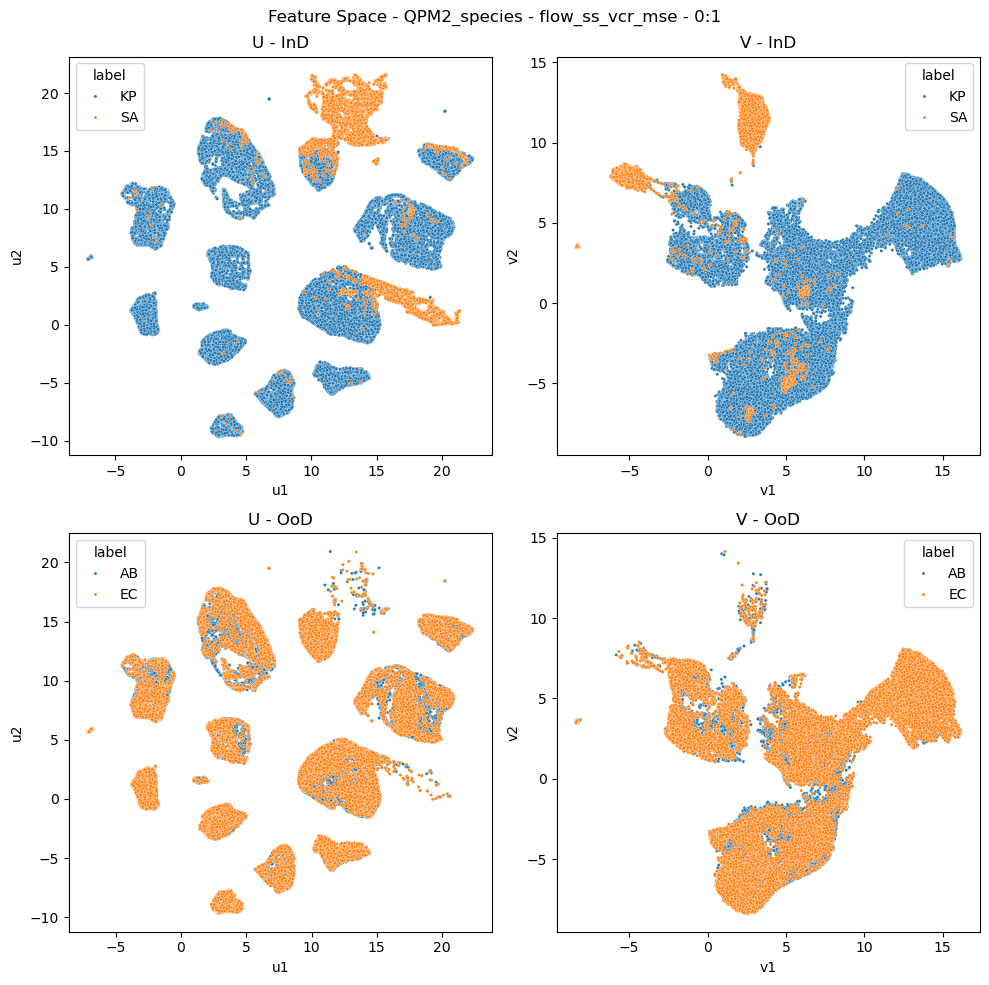

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

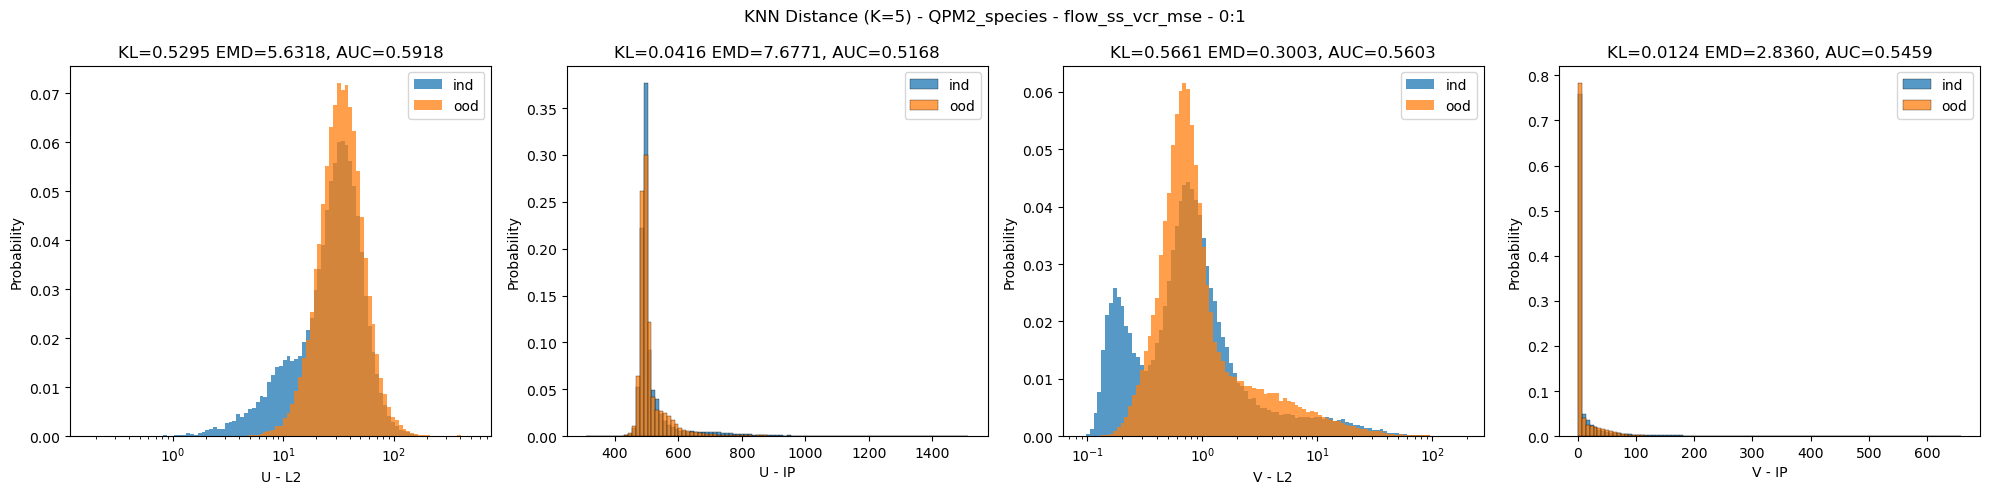

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

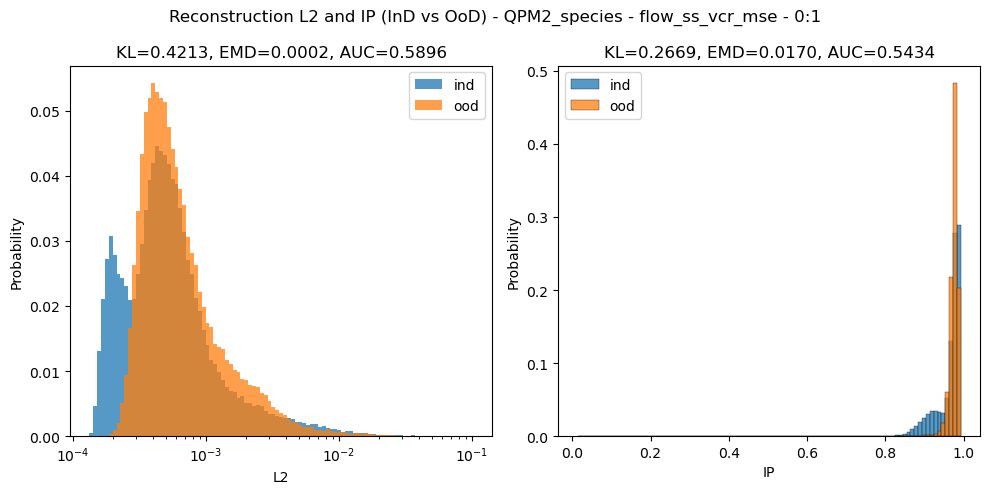

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

23.192745 1.2799791 2.6159558 2.7041476
23.21045 1.3285273 2.6627219 2.8003974
22.90025 1.0041164 2.032219 2.085618
22.893578 0.8311121 2.0025437 1.7824475
34.794445 1.0339442 56.933582 0.7127326


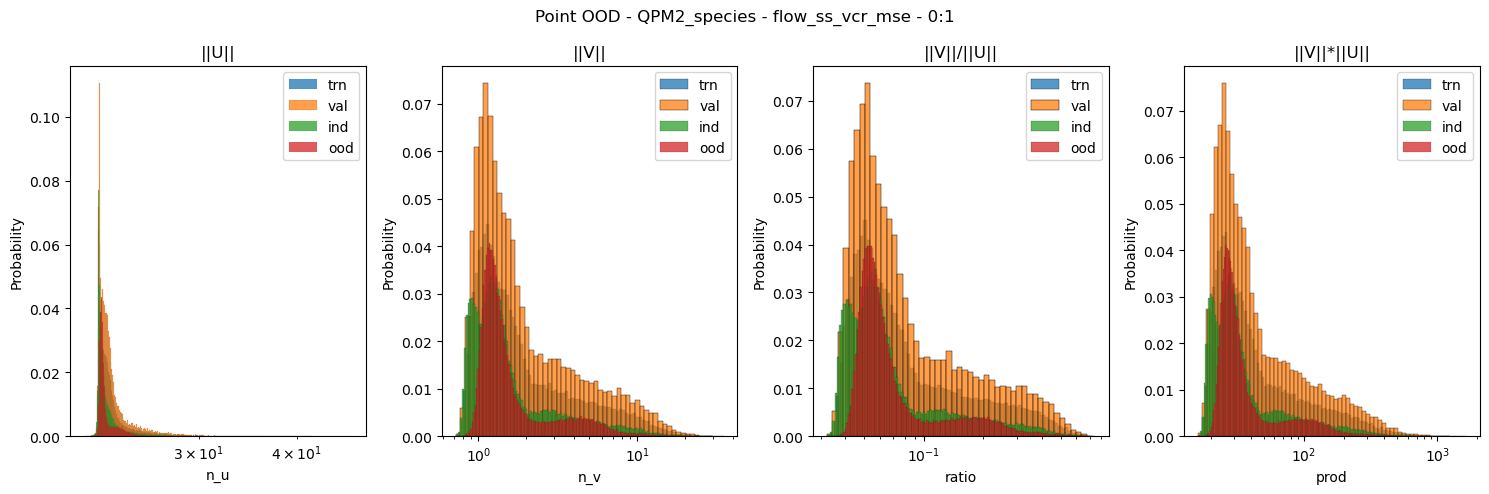

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


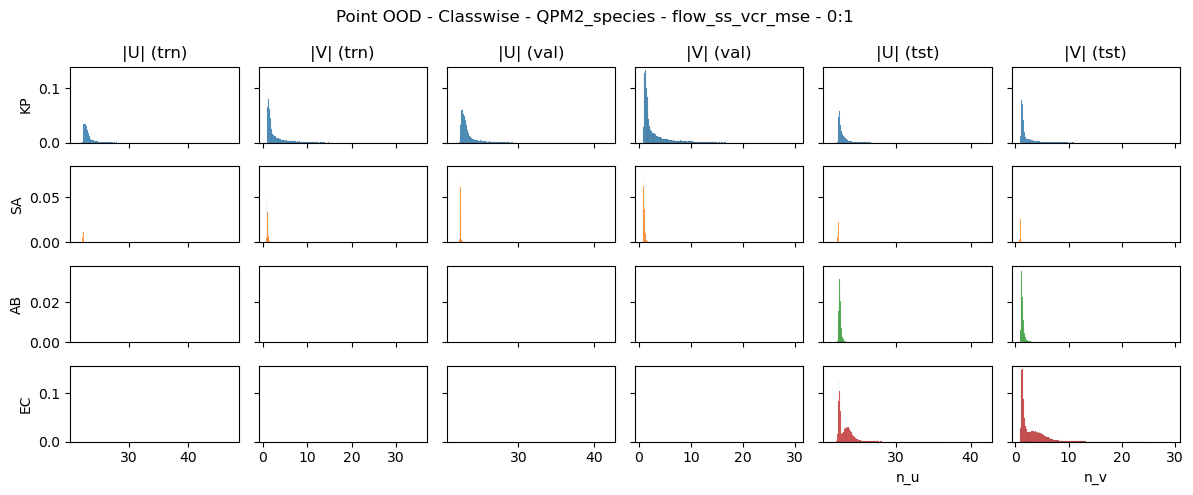

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

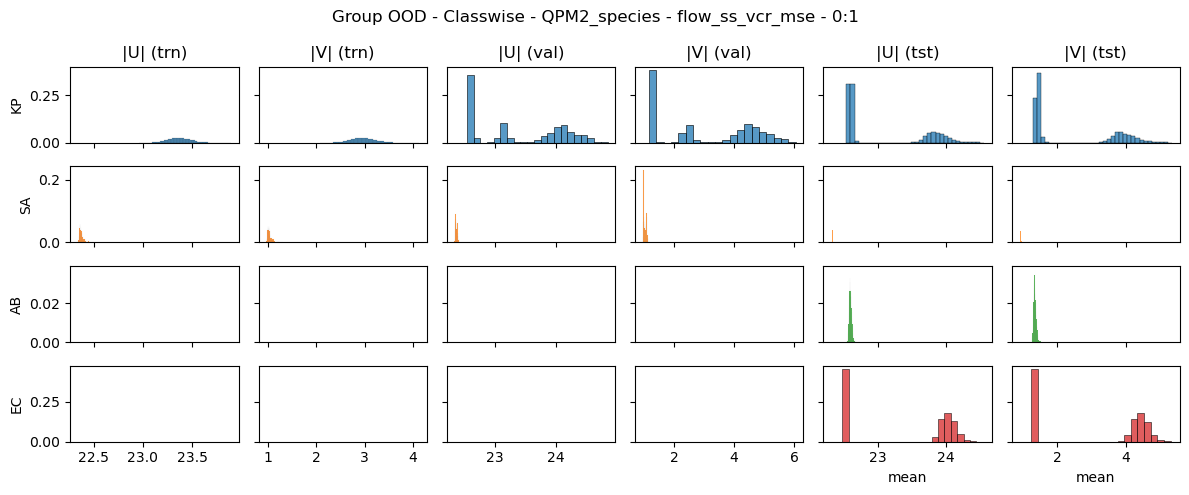

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()